Below based on `preprocess.ipynb` by Mohsen Bagherimehrab, at Zapata repository

In [1]:
import pandas as pd
import ehm_dmrg.ehm_utils as ehm_utils
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.spatial

/home/jtcantin/utoronto/ehm_dmrg/ehm_dmrg/env_ehm_dmrg/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#Preprocessing
rawdata = pd.read_csv('combined_df.csv', index_col=None)
[column for column in rawdata.columns]

['hamiltonian_id',
 'num_orbitals',
 'num_electrons',
 'num_spin_orbitals',
 'two_S',
 'orbsym',
 'isym',
 'total_num_states',
 'log10_hilbert_space_size',
 'tbt_matrices_calc_time_s',
 'bandwidth_calc_time_s',
 'coulomb_matrix_bandwidth_upper',
 'coulomb_matrix_bandwidth_lower',
 'exchange_matrix_bandwidth_upper',
 'exchange_matrix_bandwidth_lower',
 'mean_field_matrix_bandwidth_upper',
 'mean_field_matrix_bandwidth_lower',
 'coulomb_calc_time_s',
 'coulomb_matrix_algebraic_connectivity',
 'coulomb_matrix_transitivity',
 'coulomb_matrix_edgeCount',
 'coulomb_matrix_graph_creation_time',
 'coulomb_matrix_algebraic_connectivity_calc_time_s',
 'coulomb_matrix_transitivity_calc_time_s',
 'coulomb_matrix_specA_min',
 'coulomb_matrix_specA_Q2',
 'coulomb_matrix_specA_max',
 'coulomb_matrix_specA_mean',
 'coulomb_matrix_specA_std',
 'coulomb_matrix_specA_coeff_variation',
 'coulomb_matrix_specA_power_spectral_entropy',
 'coulomb_matrix_specA_calc_time_s',
 'coulomb_matrix_specA_stat_calc_tim

In [3]:
# Before applying the preprocessing, we now reduced the raw dataset for one solver.
rawdata_coarse_bd = rawdata.drop(['total_loops_cpu_time_sec'], axis=1)
hamiltonian_id = rawdata_coarse_bd['hamiltonian_id']
rawdata_coarse_bd = rawdata_coarse_bd.drop(['total_loops_wall_time_sec'], axis=1)
rawdata_coarse_bd = rawdata_coarse_bd.drop(['hamiltonian_id'], axis=1)
rawdata_coarse_bd = rawdata_coarse_bd.drop(['orbsym'], axis=1)
rawdata_coarse_bd

,num_orbitals,num_electrons,num_spin_orbitals,two_S,isym,total_num_states,log10_hilbert_space_size,tbt_matrices_calc_time_s,bandwidth_calc_time_s,coulomb_matrix_bandwidth_upper,...,hubbard_distance_calc_time_s,obt_l2_norm,obt_diag_l2_norm,obt_diag_orig_l2_ratio,tbt_l2_norm,tbt_diag_l2_norm,tbt_diag_orig_l2_ratio,diagonal_dominance,diagonal_dominance_calc_time_s,coarse_bond_dimension
0,16,18,32,0,1,4.714356e+08,8.673422,0.000037,0.000049,15,...,0.093078,19.050578,45.595818,2.393409,7.245472,4.026223,0.555688,2.949097,0.008731,5
1,39,50,78,0,1,1.221223e+21,21.086795,0.000135,0.000029,38,...,0.011196,27.419685,93.461373,3.408550,12.077686,6.113896,0.506214,3.914764,0.024509,15
2,6,8,12,0,1,4.950000e+02,2.694605,0.000439,0.000358,5,...,0.000323,6.060295,11.192867,1.846918,3.280063,1.907076,0.581415,2.428332,0.000092,5
3,28,34,56,0,1,2.142582e+15,15.330938,0.000153,0.000025,27,...,0.003242,21.145553,63.234225,2.990427,10.116799,5.176423,0.511666,3.502093,0.024683,27
4,25,30,50,0,1,4.712921e+13,13.673290,0.000040,0.000023,24,...,0.002782,20.824048,58.487200,2.808637,9.270778,4.935153,0.532334,3.340972,0.019528,8
5,9,12,18,0,1,1.856400e+04,4.268672,0.000579,0.000449,8,...,0.000141,8.433882,18.239439,2.162639,5.028479,2.732513,0.543407,2.706046,0.000145,9
6,14,22,28,0,1,3.767400e+05,5.576042,0.000042,0.000025,13,...,0.002229,10.641383,30.905188,2.904245,6.159087,3.205206,0.520403,3.424648,0.006821,7
7,33,46,66,0,1,4.066117e+16,16.609180,0.000066,0.000025,32,...,0.094925,12.856182,62.030199,4.824932,9.723939,4.599275,0.472985,5.297916,0.040287,104
8,46,58,92,0,1,1.792375e+25,25.253429,0.000150,0.000028,45,...,0.033005,17.840595,94.482983,5.295955,13.566210,6.173533,0.455067,5.751022,0.083238,8
9,33,45,66,1,1,8.906733e+16,16.949718,0.000058,0.000023,32,...,0.007318,12.779242,61.926301,4.845851,9.798468,4.639426,0.473485,5.319336,0.037281,449


In [4]:
# temp_df = rawdata_coarse_bd#.drop(["log10_hilbert_space_size"], axis=1)
# temp_df = temp_df.drop(["coarse_bond_dimension"], axis=1)
# #divide all  columns with log10_hilbert_space_size
# temp_df = temp_df.div(rawdata_coarse_bd["log10_hilbert_space_size"], axis=0)
# temp_df = temp_df.drop(["log10_hilbert_space_size"], axis=1)
# # Add back the log10_hilbert_space_size and coarse_bond_dimension
# temp_df["log10_hilbert_space_size"] = rawdata_coarse_bd["log10_hilbert_space_size"]
# temp_df["coarse_bond_dimension"] = rawdata_coarse_bd["coarse_bond_dimension"]
# rawdata_coarse_bd_hspace_normalized = temp_df
# # rawdata_coarse_bd_hspace_normalized

In [5]:
# We now apply the preprocessing

target = 'coarse_bond_dimension'

rawdata_coarse_bd[target] = np.log10(rawdata_coarse_bd[target])

preproc_df_coarse_bd = ehm_utils.preprocess(rawdata_coarse_bd, target, normalize_target=True)
# preproc_df_coarse_bd, compenents, singular_values, feature_names = ehm_utils.preprocess(rawdata_coarse_bd_hspace_normalized, target, normalize_target=True,pca_decorrelation=True)
preproc_df_coarse_bd

,num_orbitals,num_electrons,num_spin_orbitals,two_S,total_num_states,log10_hilbert_space_size,tbt_matrices_calc_time_s,bandwidth_calc_time_s,coulomb_matrix_bandwidth_upper,coulomb_calc_time_s,...,hubbard_distance_calc_time_s,obt_l2_norm,obt_diag_l2_norm,obt_diag_orig_l2_ratio,tbt_l2_norm,tbt_diag_l2_norm,tbt_diag_orig_l2_ratio,diagonal_dominance,diagonal_dominance_calc_time_s,coarse_bond_dimension
0,-1.088973,-1.292059,-1.088973,-0.326161,-0.176452,-0.855867,-0.729592,-0.146522,-1.088973,-0.315217,...,0.328869,-0.435363,-1.028381,-1.417738,-0.797295,-0.628309,1.103027,-1.420276,-0.917129,-1.150156
1,0.458660,0.184580,0.458660,-0.326161,-0.176452,0.728556,-0.044807,-0.317755,0.458660,-0.291893,...,-0.755522,0.385497,0.280252,-0.138686,0.451337,0.400766,-0.302288,-0.157813,-0.646184,-0.367566
2,-1.761857,-1.753509,-1.761857,-0.326161,-0.176452,-1.618994,2.066785,2.399559,-1.761857,-0.257410,...,-0.899520,-1.709477,-1.968949,-2.106302,-1.821946,-1.672897,1.833791,-2.101096,-1.065484,-1.150156
3,-0.281513,-0.553740,-0.281513,-0.326161,-0.176452,-0.006112,0.078115,-0.347507,-0.281513,-0.290188,...,-0.860858,-0.229883,-0.546151,-0.665511,-0.055351,-0.061342,-0.147426,-0.697318,-0.643200,0.051140
4,-0.483378,-0.738320,-0.483378,-0.326161,-0.176452,-0.217692,-0.708751,-0.365907,-0.483378,-0.300866,...,-0.866953,-0.261417,-0.675933,-0.894560,-0.273961,-0.180270,0.439659,-0.907960,-0.731714,-0.815352
5,-1.559992,-1.568929,-1.559992,-0.326161,-0.176452,-1.418082,3.045322,3.158010,-1.559992,-0.293423,...,-0.901925,-1.476671,-1.776298,-1.708502,-1.370160,-1.266016,0.754190,-1.738028,-1.064569,-0.731450
6,-1.223550,-1.107479,-1.223550,-0.326161,-0.176452,-1.251212,-0.694458,-0.352275,-1.223550,-0.312289,...,-0.874279,-1.260155,-1.430019,-0.774097,-1.078014,-1.033012,0.100741,-0.798565,-0.949928,-0.910472
7,0.054929,0.000000,0.054929,-0.326161,-0.176452,0.157040,-0.531268,-0.348053,0.054929,1.291830,...,0.353321,-1.042922,-0.579069,1.645918,-0.156865,-0.345834,-1.246173,1.650447,-0.375235,1.011774
8,0.929678,0.553740,0.929678,-0.326161,-0.174433,1.260378,0.057845,-0.327348,0.929678,6.273470,...,-0.466703,-0.554041,0.308183,2.239394,0.835967,0.430163,-1.755133,2.242813,0.362345,-0.815352
9,0.054929,-0.046145,0.054929,1.005663,-0.176452,0.200506,-0.584778,-0.362685,0.054929,0.005433,...,-0.806885,-1.050469,-0.581909,1.672275,-0.137607,-0.326043,-1.231969,1.678450,-0.426858,2.053670


In [6]:
# # Decorrelate data with eigendecomposition of correlation matrix
# #Store target
# target = preproc_df_coarse_bd['coarse_bond_dimension']
# #Drop target from dataframe
# preproc_df_coarse_bd = preproc_df_coarse_bd.drop(['coarse_bond_dimension'], axis=1)
# #Compute correlation matrix
# correlation_df = preproc_df_coarse_bd.corr()
# #Compute eigenvalues and eigenvectors
# eigenvalues, eigenvectors = np.linalg.eigh(correlation_df)
# #Sort eigenvalues
# sorted_indices = np.argsort(eigenvalues)[::-1]
# sorted_eigenvalues = eigenvalues[sorted_indices]
# sorted_eigenvectors = eigenvectors[:, sorted_indices]
# #Decorrelate data
# decorrelated_data = np.dot(preproc_df_coarse_bd, sorted_eigenvectors)
# #Make dataframe
# decorrelated_df = pd.DataFrame(decorrelated_data)
# #Add target back
# decorrelated_df['coarse_bond_dimension'] = target

In [7]:
# decorrelated_df

In [8]:
# decorrelated_df.corr()

In [9]:
# # print full U matrix  without summary
# np.set_printoptions(threshold=np.inf)

# for row in np.log10(np.abs(U)).T:
#     print(np.max(row), np.argmax(row))
#     print(np.min(row), np.argmin(row))

In [10]:
# #Plot singular values
# plt.plot(s)
# plt.xlabel('Singular value index')
# plt.ylabel('Singular value')
# plt.title('Singular values of correlation matrix')
# # y axislog 
# plt.yscale('log')
# plt.show()

In [11]:
# [column for column in preproc_df_coarse_bd.columns]
# print(len(preproc_df_coarse_bd.columns))

In [12]:
# features_to_keep =[
# ##Positive correlation for below
# ###
# "log10_hilbert_space_size", # PCC 0.287628 with coarse_bond_dimension
# "num_orbitals", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "coulomb_matrix_bandwidth_upper", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "coulomb_matrix_algebraic_connectivity",
# "coulomb_matrix_edgeCount", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "coulomb_matrix_specA_max",
# "coulomb_matrix_specA_power_spectral_entropy", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "coulomb_matrix_specR_power_spectral_entropy", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "exchange_matrix_specA_power_spectral_entropy", # PCC 0.395203 with coarse_bond_dimension  ##################################################
# "exchange_matrix_specR_min",
# "exchange_matrix_specR_power_spectral_entropy", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "mean_field_calc_time_s",
# "mean_field_matrix_algebraic_connectivity", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "mean_field_matrix_algebraic_connectivity_calc_time_s",
# "mean_field_matrix_specA_max",
# "mean_field_matrix_specA_power_spectral_entropy", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "mean_field_matrix_specL_std", #Important for DT?
# "mean_field_matrix_specR_power_spectral_entropy", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "tbt_graph_mapping_calc_time_s", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "tbt_abs_graph_mapping_calc_time_s",
# "tbt_abs_graph_mapping_algebraic_connectivity", # Very unique, split correlation, strong
# "tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s",
# "tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s",
# "tbt_abs_graph_mapping_specA_min",
# "tbt_abs_graph_mapping_specA_Q2", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "tbt_abs_graph_mapping_specA_max", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "tbt_abs_graph_mapping_specA_mean", # Unique, some correlation splitting # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "tbt_abs_graph_mapping_specA_std", # PCC 0.352337 with coarse_bond_dimension # Absolute Pearson CC with tbt_abs_graph_mapping_algebraic_connectivity > 0.8 ###########################
# "tbt_abs_graph_mapping_specA_coeff_variation",
# "tbt_abs_graph_mapping_specA_power_spectral_entropy", # PCC 0.295939 with coarse_bond_dimension
# "tbt_abs_graph_mapping_specL_max", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "tbt_abs_graph_mapping_specL_std", # PCC 0.323950 with coarse_bond_dimension
# "tbt_abs_graph_mapping_specR_power_spectral_entropy", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "density_hopping_tensor_min", # PCC 0.288345 with coarse_bond_dimension
# "density_hopping_tensor_sum_abs", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# ## Negative correlation for below
# ###
# "coulomb_matrix_specL_min", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "coulomb_matrix_specL_Q2", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "coulomb_matrix_specL_mean", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "coulomb_matrix_specR_min", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "exchange_matrix_specL_coeff_variation", # PCC -0.335911 with coarse_bond_dimension
# "exchange_matrix_specL_power_spectral_entropy", # PCC -0.263279 with coarse_bond_dimension
# "exchange_matrix_specR_max", #Important for DT?
# "exchange_matrix_specR_std",
# "mean_field_matrix_specA_min", #Important for DT?  # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "mean_field_matrix_specL_min", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "mean_field_matrix_specL_Q2", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "mean_field_matrix_specL_mean", # Absolute Pearson CC with coulomb_matrix_algebraic_connectivity > 0.8
# "mean_field_matrix_specR_min", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "tbt_abs_graph_mapping_specL_coeff_variation",
# "tbt_abs_graph_mapping_specL_power_spectral_entropy",
# "tbt_abs_graph_mapping_specR_max", # PCC -0.258219 with coarse_bond_dimension
# "tbt_abs_graph_mapping_specR_coeff_variation", # PCC -0.395208 with coarse_bond_dimension ####################
# "density_hopping_tensor_coeff_variation", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
# "tbt_coeff_variation", # Absolute Pearson CC with log10_hilbert_space_size > 0.8
    
# ]
# features_to_keep =[
# # "num_orbitals",#log10_hilbert_space_size                                                 8
# # "num_electrons",#log10_hilbert_space_size                                                6
# # "num_spin_orbitals",#log10_hilbert_space_size                                            8
# # "two_S",#                                                        0
# # "total_num_states",#log10_hilbert_space_size                                             1
# # "log10_hilbert_space_size",#                                     1
# # "tbt_matrices_calc_time_s",#log10_hilbert_space_size                                     0
# # "bandwidth_calc_time_s",#                                        0
# # "coulomb_matrix_bandwidth_upper",#log10_hilbert_space_size                               8
# # "coulomb_calc_time_s",#                                          0
# # "coulomb_matrix_algebraic_connectivity",#                        0
# # "coulomb_matrix_edgeCount",#log10_hilbert_space_size                                     0
# # "coulomb_matrix_graph_creation_time",#log10_hilbert_space_size                           1
# # "coulomb_matrix_algebraic_connectivity_calc_time_s",#            0
# # "coulomb_matrix_transitivity_calc_time_s",#log10_hilbert_space_size                      0
# # "coulomb_matrix_specA_min",#                                     0
# # "coulomb_matrix_specA_Q2",#                                      0
# # "coulomb_matrix_specA_max",#                                     0
# # "coulomb_matrix_specA_mean",#                                    0
# # "coulomb_matrix_specA_std",#                                     0
# # "coulomb_matrix_specA_coeff_variation",#                         0
# # "coulomb_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size                  6
# # "coulomb_matrix_specA_calc_time_s",#                             0
# # "coulomb_matrix_specA_stat_calc_time_s",#                        0
# # "coulomb_matrix_specL_min",#                                     0
# # "coulomb_matrix_specL_Q2",#                                      0
# # "coulomb_matrix_specL_max",#                                     0
# # "coulomb_matrix_specL_mean",#                                    0
# # "coulomb_matrix_specL_std",#                                     0
# # "coulomb_matrix_specL_coeff_variation",#                         0
# # "coulomb_matrix_specL_power_spectral_entropy",#                  0
# # "coulomb_matrix_specL_calc_time_s",#                             0
# # "coulomb_matrix_specL_stat_calc_time_s",#                        0
# # "coulomb_matrix_specR_min",#log10_hilbert_space_size                                    23
# # "coulomb_matrix_specR_Q2",#                                      0
# # "coulomb_matrix_specR_max",#                                     0
# # "coulomb_matrix_specR_mean",#                                    0
# # "coulomb_matrix_specR_std",#                                     0
# # "coulomb_matrix_specR_coeff_variation",#                         0
# # "coulomb_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size                  6
# # "coulomb_matrix_specR_calc_time_s",#                             0
# # "coulomb_matrix_specR_stat_calc_time_s",#                        0
# # "exchange_calc_time_s",#log10_hilbert_space_size                                         0
# # "exchange_matrix_algebraic_connectivity",#                       0
# # "exchange_matrix_graph_creation_time",#                          0
# # "exchange_matrix_algebraic_connectivity_calc_time_s",#           0
# # "exchange_matrix_transitivity_calc_time_s",#                     0
# # "exchange_matrix_specA_min",#                                    0
# # "exchange_matrix_specA_Q2",#                                     0
# # "exchange_matrix_specA_max",#                                    0
# # "exchange_matrix_specA_mean",#                                   0
# # "exchange_matrix_specA_std",#                                    0
# # "exchange_matrix_specA_coeff_variation",#                        0
# # "exchange_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size                 1
# # "exchange_matrix_specA_calc_time_s",#                            0
# # "exchange_matrix_specA_stat_calc_time_s",#                       0
# # "exchange_matrix_specL_min",#                                    0
# # "exchange_matrix_specL_Q2",#                                     0
# # "exchange_matrix_specL_max",#                                    0
# # "exchange_matrix_specL_mean",#                                   0
# # "exchange_matrix_specL_std",#                                    0
# # "exchange_matrix_specL_coeff_variation",#                        0
# # "exchange_matrix_specL_power_spectral_entropy",#                 0
# # "exchange_matrix_specL_calc_time_s",#                            0
# # "exchange_matrix_specL_stat_calc_time_s",#                       0
# # "exchange_matrix_specR_min",#                                    0
# # "exchange_matrix_specR_Q2",#                                     0
# # "exchange_matrix_specR_max",#                                    0
# # "exchange_matrix_specR_mean",#                                   0
# # "exchange_matrix_specR_std",#                                    0
# # "exchange_matrix_specR_coeff_variation",#                        0
# # "exchange_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size                 6
# # "exchange_matrix_specR_calc_time_s",#                            0
# # "exchange_matrix_specR_stat_calc_time_s",#                       0
# # "mean_field_calc_time_s",#                                       0
# # "mean_field_matrix_algebraic_connectivity",#                     0
# # "mean_field_matrix_graph_creation_time",#                        0
# # "mean_field_matrix_algebraic_connectivity_calc_time_s",#         0
# # "mean_field_matrix_transitivity_calc_time_s",#log10_hilbert_space_size                   0
# # "mean_field_matrix_specA_min",#                                  0
# # "mean_field_matrix_specA_Q2",#                                   0
# # "mean_field_matrix_specA_max",#                                  0
# # "mean_field_matrix_specA_mean",#                                 0
# # "mean_field_matrix_specA_std",#                                  0
# # "mean_field_matrix_specA_coeff_variation",#                      0
# # "mean_field_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size               6
# # "mean_field_matrix_specA_calc_time_s",#log10_hilbert_space_size                          0
# # "mean_field_matrix_specA_stat_calc_time_s",#                     0
# # "mean_field_matrix_specL_min",#                                  0
# # "mean_field_matrix_specL_Q2",#                                   0
# # "mean_field_matrix_specL_max",#                                  0
# # "mean_field_matrix_specL_mean",#                                 0
# # "mean_field_matrix_specL_std",#                                  0
# # "mean_field_matrix_specL_coeff_variation",#                      0
# "mean_field_matrix_specL_power_spectral_entropy",#               0
# # "mean_field_matrix_specL_calc_time_s",#                          0
# # "mean_field_matrix_specL_stat_calc_time_s",#                     0
# # "mean_field_matrix_specR_min",#log10_hilbert_space_size                                 22
# # "mean_field_matrix_specR_Q2",#                                   0
# # "mean_field_matrix_specR_max",#                                  0
# # "mean_field_matrix_specR_mean",#                                 0
# # "mean_field_matrix_specR_std",#                                  0
# # "mean_field_matrix_specR_coeff_variation",#                      0
# # "mean_field_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size               6
# # "mean_field_matrix_specR_calc_time_s",#                          0
# # "mean_field_matrix_specR_stat_calc_time_s",#                     0
# # "tbt_graph_mapping_calc_time_s",#log10_hilbert_space_size                                0
# # "tbt_abs_graph_mapping_calc_time_s",#                            0
# # "tbt_abs_graph_mapping_algebraic_connectivity",#                 0
# # "tbt_abs_graph_mapping_graph_creation_time",#log10_hilbert_space_size                    0
# # "tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s",#     0
# # "tbt_abs_graph_mapping_transitivity_calc_time_s",#               0
# # "tbt_abs_graph_mapping_specA_min",#                              0
# # "tbt_abs_graph_mapping_specA_Q2",#                               0
# # "tbt_abs_graph_mapping_specA_max",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specA_mean",#                             0
# # "tbt_abs_graph_mapping_specA_std",#                              0
# # "tbt_abs_graph_mapping_specA_coeff_variation",#                  0
# "tbt_abs_graph_mapping_specA_power_spectral_entropy",#           0
# # "tbt_abs_graph_mapping_specA_calc_time_s",#log10_hilbert_space_size                      0
# # "tbt_abs_graph_mapping_specA_stat_calc_time_s",#                 0
# # "tbt_abs_graph_mapping_specL_min",#                              0
# # "tbt_abs_graph_mapping_specL_Q2",#log10_hilbert_space_size                               0
# "tbt_abs_graph_mapping_specL_max",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specL_mean",#log10_hilbert_space_size                             0
# # "tbt_abs_graph_mapping_specL_std",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specL_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specL_power_spectral_entropy",#           0
# # "tbt_abs_graph_mapping_specL_calc_time_s",#log10_hilbert_space_size                      0
# # "tbt_abs_graph_mapping_specL_stat_calc_time_s",#                 0
# # "tbt_abs_graph_mapping_specR_min",#                              0
# # "tbt_abs_graph_mapping_specR_Q2",#                               0
# # "tbt_abs_graph_mapping_specR_max",#                              0
# # "tbt_abs_graph_mapping_specR_mean",#                             0
# # "tbt_abs_graph_mapping_specR_std",#                              0
# # "tbt_abs_graph_mapping_specR_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specR_power_spectral_entropy",#log10_hilbert_space_size           6
# # "tbt_abs_graph_mapping_specR_calc_time_s",#                      0
# # "tbt_abs_graph_mapping_specR_stat_calc_time_s",#                 0
# # "one_body_tensor_calc_time_s",#                                  0
# # "one_body_tensor_bandwidth_upper",#log10_hilbert_space_size                              7
# # "one_body_tensor_bandwidth_lower",#log10_hilbert_space_size                              8
# # "density_hopping_tensor_mean",#                                  0
# # "density_hopping_tensor_std",#                                   0
# # "density_hopping_tensor_max",#                                   0
# "density_hopping_tensor_min",#                                   0
# # "density_hopping_tensor_coeff_variation",#log10_hilbert_space_size                       0
# # "density_hopping_tensor_inv_coeff_variation",#log10_hilbert_space_size                   0
# # "density_hopping_tensor_sum_abs",# log10_hilbert_space_size                              0
# # "tbt_density_hopping_calc_time_s",#                              0
# # "tbt_mean",#                                                     0
# # "tbt_std",#                                                      0
# # "tbt_max",#                                                      0
# # "tbt_coeff_variation",#log10_hilbert_space_size                                         12
# # "tbt_inv_coeff_variation",#                                      0
# # "tbt_calc_time_s",#                                              0
# "coarse_bond_dimension",#                                       20
# ]
# features_to_keep =[
# 132, #                     0.464184
# 75,  #                     0.447602
# 129, #                     0.403590
# 105, #                     0.400790
# 155, #                     0.360431
# 0,   #                     0.356010
# 71,  #                     0.345408
# 55,  #                     0.344435
# 144, #                     0.332154
# 48,  #                     0.326521
# 59,  #                     0.325584
# 86,  #                     0.313738
# 96,  #                     0.306352
# "121", #                     0.301793
# "coarse_bond_dimension",#                                       20
# ]
# features_to_keep =[ #non-log DT topfeatures
# # "num_orbitals",#log10_hilbert_space_size                                                 8
# # "num_electrons",#log10_hilbert_space_size                                                6
# # "num_spin_orbitals",#log10_hilbert_space_size                                            8
# # "two_S",#                                                        0
# # "total_num_states",#log10_hilbert_space_size                                             1
# # "log10_hilbert_space_size",#                                     1
# # "tbt_matrices_calc_time_s",#log10_hilbert_space_size                                     0
# # "bandwidth_calc_time_s",#                                        0
# # "coulomb_matrix_bandwidth_upper",#log10_hilbert_space_size                               8
# # "coulomb_calc_time_s",#                                          0
# # "coulomb_matrix_algebraic_connectivity",#                        0
# # "coulomb_matrix_edgeCount",#log10_hilbert_space_size                                     0
# # "coulomb_matrix_graph_creation_time",#log10_hilbert_space_size                           1
# # "coulomb_matrix_algebraic_connectivity_calc_time_s",#            0
# # "coulomb_matrix_transitivity_calc_time_s",#log10_hilbert_space_size                      0
# # "coulomb_matrix_specA_min",#                                     0
# # "coulomb_matrix_specA_Q2",#                                      0
# # "coulomb_matrix_specA_max",#                                     0
# # "coulomb_matrix_specA_mean",#                                    0
# # "coulomb_matrix_specA_std",#                                     0
# # "coulomb_matrix_specA_coeff_variation",#                         0
# # "coulomb_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size                  6
# # "coulomb_matrix_specA_calc_time_s",#                             0
# # "coulomb_matrix_specA_stat_calc_time_s",#                        0
# # "coulomb_matrix_specL_min",#                                     0
# # "coulomb_matrix_specL_Q2",#                                      0
# # "coulomb_matrix_specL_max",#                                     0
# # "coulomb_matrix_specL_mean",#                                    0
# # "coulomb_matrix_specL_std",#                                     0
# # "coulomb_matrix_specL_coeff_variation",#                         0
# # "coulomb_matrix_specL_power_spectral_entropy",#                  0
# # "coulomb_matrix_specL_calc_time_s",#                             0
# # "coulomb_matrix_specL_stat_calc_time_s",#                        0
# # "coulomb_matrix_specR_min",#log10_hilbert_space_size                                    23
# # "coulomb_matrix_specR_Q2",#                                      0
# # "coulomb_matrix_specR_max",#                                     0
# # "coulomb_matrix_specR_mean",#                                    0
# # "coulomb_matrix_specR_std",#                                     0
# # "coulomb_matrix_specR_coeff_variation",#                         0
# # "coulomb_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size                  6
# # "coulomb_matrix_specR_calc_time_s",#                             0
# # "coulomb_matrix_specR_stat_calc_time_s",#                        0
# # "exchange_calc_time_s",#log10_hilbert_space_size                                         0
# # "exchange_matrix_algebraic_connectivity",#                       0
# # "exchange_matrix_graph_creation_time",#                          0
# # "exchange_matrix_algebraic_connectivity_calc_time_s",#           0
# # "exchange_matrix_transitivity_calc_time_s",#                     0
# # "exchange_matrix_specA_min",#                                    0
# # "exchange_matrix_specA_Q2",#                                     0
# # "exchange_matrix_specA_max",#                                    0
# # "exchange_matrix_specA_mean",#                                   0
# # "exchange_matrix_specA_std",#                                    0
# # "exchange_matrix_specA_coeff_variation",#                        0
# # "exchange_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size                 1
# # "exchange_matrix_specA_calc_time_s",#                            0
# # "exchange_matrix_specA_stat_calc_time_s",#                       0
# "exchange_matrix_specL_min",#                                    0
# # "exchange_matrix_specL_Q2",#                                     0
# # "exchange_matrix_specL_max",#                                    0
# # "exchange_matrix_specL_mean",#                                   0
# # "exchange_matrix_specL_std",#                                    0
# # "exchange_matrix_specL_coeff_variation",#                        0
# # "exchange_matrix_specL_power_spectral_entropy",#                 0
# # "exchange_matrix_specL_calc_time_s",#                            0
# # "exchange_matrix_specL_stat_calc_time_s",#                       0
# # "exchange_matrix_specR_min",#                                    0
# # "exchange_matrix_specR_Q2",#                                     0
# # "exchange_matrix_specR_max",#                                    0
# # "exchange_matrix_specR_mean",#                                   0
# # "exchange_matrix_specR_std",#                                    0
# "exchange_matrix_specR_coeff_variation",#                        0
# # "exchange_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size                 6
# # "exchange_matrix_specR_calc_time_s",#                            0
# # "exchange_matrix_specR_stat_calc_time_s",#                       0
# # "mean_field_calc_time_s",#                                       0
# # "mean_field_matrix_algebraic_connectivity",#                     0
# # "mean_field_matrix_graph_creation_time",#                        0
# # "mean_field_matrix_algebraic_connectivity_calc_time_s",#         0
# # "mean_field_matrix_transitivity_calc_time_s",#log10_hilbert_space_size                   0
# "mean_field_matrix_specA_min",#                                  0
# # "mean_field_matrix_specA_Q2",#                                   0
# # "mean_field_matrix_specA_max",#                                  0
# # "mean_field_matrix_specA_mean",#                                 0
# # "mean_field_matrix_specA_std",#                                  0
# # "mean_field_matrix_specA_coeff_variation",#                      0
# # "mean_field_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size               6
# # "mean_field_matrix_specA_calc_time_s",#log10_hilbert_space_size                          0
# # "mean_field_matrix_specA_stat_calc_time_s",#                     0
# # "mean_field_matrix_specL_min",#                                  0
# # "mean_field_matrix_specL_Q2",#                                   0
# # "mean_field_matrix_specL_max",#                                  0
# # "mean_field_matrix_specL_mean",#                                 0
# # "mean_field_matrix_specL_std",#                                  0
# # "mean_field_matrix_specL_coeff_variation",#                      0
# "mean_field_matrix_specL_power_spectral_entropy",#               0
# # "mean_field_matrix_specL_calc_time_s",#                          0
# # "mean_field_matrix_specL_stat_calc_time_s",#                     0
# # "mean_field_matrix_specR_min",#log10_hilbert_space_size                                 22
# # "mean_field_matrix_specR_Q2",#                                   0
# # "mean_field_matrix_specR_max",#                                  0
# # "mean_field_matrix_specR_mean",#                                 0
# # "mean_field_matrix_specR_std",#                                  0
# # "mean_field_matrix_specR_coeff_variation",#                      0
# # "mean_field_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size               6
# # "mean_field_matrix_specR_calc_time_s",#                          0
# # "mean_field_matrix_specR_stat_calc_time_s",#                     0
# # "tbt_graph_mapping_calc_time_s",#log10_hilbert_space_size                                0
# # "tbt_abs_graph_mapping_calc_time_s",#                            0
# # "tbt_abs_graph_mapping_algebraic_connectivity",#                 0
# # "tbt_abs_graph_mapping_graph_creation_time",#log10_hilbert_space_size                    0
# # "tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s",#     0
# # "tbt_abs_graph_mapping_transitivity_calc_time_s",#               0
# # "tbt_abs_graph_mapping_specA_min",#                              0
# # "tbt_abs_graph_mapping_specA_Q2",#                               0
# # "tbt_abs_graph_mapping_specA_max",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specA_mean",#                             0
# # "tbt_abs_graph_mapping_specA_std",#                              0
# # "tbt_abs_graph_mapping_specA_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specA_power_spectral_entropy",#           0
# # "tbt_abs_graph_mapping_specA_calc_time_s",#log10_hilbert_space_size                      0
# # "tbt_abs_graph_mapping_specA_stat_calc_time_s",#                 0
# # "tbt_abs_graph_mapping_specL_min",#                              0
# # "tbt_abs_graph_mapping_specL_Q2",#log10_hilbert_space_size                               0
# # "tbt_abs_graph_mapping_specL_max",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specL_mean",#log10_hilbert_space_size                             0
# # "tbt_abs_graph_mapping_specL_std",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specL_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specL_power_spectral_entropy",#           0
# # "tbt_abs_graph_mapping_specL_calc_time_s",#log10_hilbert_space_size                      0
# # "tbt_abs_graph_mapping_specL_stat_calc_time_s",#                 0
# # "tbt_abs_graph_mapping_specR_min",#                              0
# # "tbt_abs_graph_mapping_specR_Q2",#                               0
# # "tbt_abs_graph_mapping_specR_max",#                              0
# # "tbt_abs_graph_mapping_specR_mean",#                             0
# # "tbt_abs_graph_mapping_specR_std",#                              0
# "tbt_abs_graph_mapping_specR_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specR_power_spectral_entropy",#log10_hilbert_space_size           6
# # "tbt_abs_graph_mapping_specR_calc_time_s",#                      0
# # "tbt_abs_graph_mapping_specR_stat_calc_time_s",#                 0
# # "one_body_tensor_calc_time_s",#                                  0
# # "one_body_tensor_bandwidth_upper",#log10_hilbert_space_size                              7
# # "one_body_tensor_bandwidth_lower",#log10_hilbert_space_size                              8
# # "density_hopping_tensor_mean",#                                  0
# "density_hopping_tensor_std",#                                   0
# # "density_hopping_tensor_max",#                                   0
# "density_hopping_tensor_min",#                                   0
# # "density_hopping_tensor_coeff_variation",#log10_hilbert_space_size                       0
# # "density_hopping_tensor_inv_coeff_variation",#log10_hilbert_space_size                   0
# # "density_hopping_tensor_sum_abs",# log10_hilbert_space_size                              0
# # "tbt_density_hopping_calc_time_s",#                              0
# # "tbt_mean",#                                                     0
# # "tbt_std",#                                                      0
# # "tbt_max",#                                                      0
# # "tbt_coeff_variation",#log10_hilbert_space_size                                         12
# # "tbt_inv_coeff_variation",#                                      0
# # "tbt_calc_time_s",#                                              0
# "coarse_bond_dimension",#                                       20
# ]
# features_to_keep =[ # WHAT WAS SHOWN AT TUES MEETING
# # "num_orbitals",#log10_hilbert_space_size                                                 8
# # "num_electrons",#log10_hilbert_space_size                                                6
# # "num_spin_orbitals",#log10_hilbert_space_size                                            8
# # "two_S",#                                                        0
# # "total_num_states",#log10_hilbert_space_size                                             1
# # "log10_hilbert_space_size",#                                     1
# # "tbt_matrices_calc_time_s",#log10_hilbert_space_size                                     0
# # "bandwidth_calc_time_s",#                                        0
# # "coulomb_matrix_bandwidth_upper",#log10_hilbert_space_size                               8
# # "coulomb_calc_time_s",#                                          0
# # "coulomb_matrix_algebraic_connectivity",#                        0
# # "coulomb_matrix_edgeCount",#log10_hilbert_space_size                                     0
# # "coulomb_matrix_graph_creation_time",#log10_hilbert_space_size                           1
# # "coulomb_matrix_algebraic_connectivity_calc_time_s",#            0
# # "coulomb_matrix_transitivity_calc_time_s",#log10_hilbert_space_size                      0
# # "coulomb_matrix_specA_min",#                                     0
# # "coulomb_matrix_specA_Q2",#                                      0
# # "coulomb_matrix_specA_max",#                                     0
# # "coulomb_matrix_specA_mean",#                                    0
# # "coulomb_matrix_specA_std",#                                     0
# # "coulomb_matrix_specA_coeff_variation",#                         0
# # "coulomb_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size                  6
# # "coulomb_matrix_specA_calc_time_s",#                             0
# # "coulomb_matrix_specA_stat_calc_time_s",#                        0
# # "coulomb_matrix_specL_min",#                                     0
# # "coulomb_matrix_specL_Q2",#                                      0
# # "coulomb_matrix_specL_max",#                                     0
# # "coulomb_matrix_specL_mean",#                                    0
# # "coulomb_matrix_specL_std",#                                     0
# # "coulomb_matrix_specL_coeff_variation",#                         0
# # "coulomb_matrix_specL_power_spectral_entropy",#                  0
# # "coulomb_matrix_specL_calc_time_s",#                             0
# # "coulomb_matrix_specL_stat_calc_time_s",#                        0
# # "coulomb_matrix_specR_min",#log10_hilbert_space_size                                    23
# # "coulomb_matrix_specR_Q2",#                                      0
# # "coulomb_matrix_specR_max",#                                     0
# # "coulomb_matrix_specR_mean",#                                    0
# # "coulomb_matrix_specR_std",#                                     0
# # "coulomb_matrix_specR_coeff_variation",#                         0
# # "coulomb_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size                  6
# # "coulomb_matrix_specR_calc_time_s",#                             0
# # "coulomb_matrix_specR_stat_calc_time_s",#                        0
# # "exchange_calc_time_s",#log10_hilbert_space_size                                         0
# # "exchange_matrix_algebraic_connectivity",#                       0
# # "exchange_matrix_graph_creation_time",#                          0
# # "exchange_matrix_algebraic_connectivity_calc_time_s",#           0
# "exchange_matrix_transitivity_calc_time_s",#                     0
# # "exchange_matrix_specA_min",#                                    0
# # "exchange_matrix_specA_Q2",#                                     0
# # "exchange_matrix_specA_max",#                                    0
# # "exchange_matrix_specA_mean",#                                   0
# # "exchange_matrix_specA_std",#                                    0
# # "exchange_matrix_specA_coeff_variation",#                        0
# # "exchange_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size                 1
# # "exchange_matrix_specA_calc_time_s",#                            0
# # "exchange_matrix_specA_stat_calc_time_s",#                       0
# # "exchange_matrix_specL_min",#                                    0
# # "exchange_matrix_specL_Q2",#                                     0
# # "exchange_matrix_specL_max",#                                    0
# "exchange_matrix_specL_mean",#                                   0
# # "exchange_matrix_specL_std",#                                    0
# # "exchange_matrix_specL_coeff_variation",#                        0
# # "exchange_matrix_specL_power_spectral_entropy",#                 0
# # "exchange_matrix_specL_calc_time_s",#                            0
# # "exchange_matrix_specL_stat_calc_time_s",#                       0
# # "exchange_matrix_specR_min",#                                    0
# # "exchange_matrix_specR_Q2",#                                     0
# # "exchange_matrix_specR_max",#                                    0
# # "exchange_matrix_specR_mean",#                                   0
# # "exchange_matrix_specR_std",#                                    0
# # "exchange_matrix_specR_coeff_variation",#                        0
# # "exchange_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size                 6
# # "exchange_matrix_specR_calc_time_s",#                            0
# # "exchange_matrix_specR_stat_calc_time_s",#                       0
# # "mean_field_calc_time_s",#                                       0
# # "mean_field_matrix_algebraic_connectivity",#                     0
# # "mean_field_matrix_graph_creation_time",#                        0
# # "mean_field_matrix_algebraic_connectivity_calc_time_s",#         0
# # "mean_field_matrix_transitivity_calc_time_s",#log10_hilbert_space_size                   0
# # "mean_field_matrix_specA_min",#                                  0
# # "mean_field_matrix_specA_Q2",#                                   0
# # "mean_field_matrix_specA_max",#                                  0
# # "mean_field_matrix_specA_mean",#                                 0
# # "mean_field_matrix_specA_std",#                                  0
# # "mean_field_matrix_specA_coeff_variation",#                      0
# # "mean_field_matrix_specA_power_spectral_entropy",#log10_hilbert_space_size               6
# # "mean_field_matrix_specA_calc_time_s",#log10_hilbert_space_size                          0
# # "mean_field_matrix_specA_stat_calc_time_s",#                     0
# # "mean_field_matrix_specL_min",#                                  0
# # "mean_field_matrix_specL_Q2",#                                   0
# # "mean_field_matrix_specL_max",#                                  0
# # "mean_field_matrix_specL_mean",#                                 0
# # "mean_field_matrix_specL_std",#                                  0
# # "mean_field_matrix_specL_coeff_variation",#                      0
# # "mean_field_matrix_specL_power_spectral_entropy",#               0
# # "mean_field_matrix_specL_calc_time_s",#                          0
# # "mean_field_matrix_specL_stat_calc_time_s",#                     0
# # "mean_field_matrix_specR_min",#log10_hilbert_space_size                                 22
# # "mean_field_matrix_specR_Q2",#                                   0
# # "mean_field_matrix_specR_max",#                                  0
# # "mean_field_matrix_specR_mean",#                                 0
# # "mean_field_matrix_specR_std",#                                  0
# # "mean_field_matrix_specR_coeff_variation",#                      0
# # "mean_field_matrix_specR_power_spectral_entropy",#log10_hilbert_space_size               6
# # "mean_field_matrix_specR_calc_time_s",#                          0
# # "mean_field_matrix_specR_stat_calc_time_s",#                     0
# # "tbt_graph_mapping_calc_time_s",#log10_hilbert_space_size                                0
# # "tbt_abs_graph_mapping_calc_time_s",#                            0
# # "tbt_abs_graph_mapping_algebraic_connectivity",#                 0
# # "tbt_abs_graph_mapping_graph_creation_time",#log10_hilbert_space_size                    0
# # "tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s",#     0
# # "tbt_abs_graph_mapping_transitivity_calc_time_s",#               0
# "tbt_abs_graph_mapping_specA_min",#                              0
# # "tbt_abs_graph_mapping_specA_Q2",#                               0
# # "tbt_abs_graph_mapping_specA_max",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specA_mean",#                             0
# # "tbt_abs_graph_mapping_specA_std",#                              0
# "tbt_abs_graph_mapping_specA_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specA_power_spectral_entropy",#           0
# # "tbt_abs_graph_mapping_specA_calc_time_s",#log10_hilbert_space_size                      0
# # "tbt_abs_graph_mapping_specA_stat_calc_time_s",#                 0
# # "tbt_abs_graph_mapping_specL_min",#                              0
# # "tbt_abs_graph_mapping_specL_Q2",#log10_hilbert_space_size                               0
# "tbt_abs_graph_mapping_specL_max",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specL_mean",#log10_hilbert_space_size                             0
# # "tbt_abs_graph_mapping_specL_std",#log10_hilbert_space_size                              0
# # "tbt_abs_graph_mapping_specL_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specL_power_spectral_entropy",#           0
# # "tbt_abs_graph_mapping_specL_calc_time_s",#log10_hilbert_space_size                      0
# # "tbt_abs_graph_mapping_specL_stat_calc_time_s",#                 0
# # "tbt_abs_graph_mapping_specR_min",#                              0
# # "tbt_abs_graph_mapping_specR_Q2",#                               0
# # "tbt_abs_graph_mapping_specR_max",#                              0
# "tbt_abs_graph_mapping_specR_mean",#                             0
# # "tbt_abs_graph_mapping_specR_std",#                              0
# # "tbt_abs_graph_mapping_specR_coeff_variation",#                  0
# # "tbt_abs_graph_mapping_specR_power_spectral_entropy",#log10_hilbert_space_size           6
# # "tbt_abs_graph_mapping_specR_calc_time_s",#                      0
# # "tbt_abs_graph_mapping_specR_stat_calc_time_s",#                 0
# # "one_body_tensor_calc_time_s",#                                  0
# # "one_body_tensor_bandwidth_upper",#log10_hilbert_space_size                              7
# # "one_body_tensor_bandwidth_lower",#log10_hilbert_space_size                              8
# # "density_hopping_tensor_mean",#                                  0
# # "density_hopping_tensor_std",#                                   0
# # "density_hopping_tensor_max",#                                   0
# # "density_hopping_tensor_min",#                                   0
# # "density_hopping_tensor_coeff_variation",#log10_hilbert_space_size                       0
# # "density_hopping_tensor_inv_coeff_variation",#log10_hilbert_space_size                   0
# # "density_hopping_tensor_sum_abs",# log10_hilbert_space_size                              0
# # "tbt_density_hopping_calc_time_s",#                              0
# # "tbt_mean",#                                                     0
# # "tbt_std",#                                                      0
# # "tbt_max",#                                                      0
# # "tbt_coeff_variation",#log10_hilbert_space_size                                         12
# # "tbt_inv_coeff_variation",#                                      0
# # "tbt_calc_time_s",#                                              0
# "coarse_bond_dimension",#                                       20
# ]
# features_to_keep =[
# # "tbt_abs_graph_mapping_specL_max",  #hubbard_dist_tbt          # 0.087448
# # "density_hopping_tensor_min", #exchange_matrix_specA_min                                   #0.063016
# "mean_field_matrix_specL_max", # Paper   # Relates to degrees of vertices, https://arxiv.org/abs/1111.2897v1                              #0.052144
# # "hubbard_dist_tbt",                                            #0.048137
# # "tbt_abs_graph_mapping_specA_max",                             #0.044520
# # "coulomb_matrix_specR_coeff_variation",                        #0.038233
# "exchange_matrix_specA_min", # Paper
# "log10_hilbert_space_size", # Paper
# ] #Seed 1012025829; See used for paper: 3116912405

# features_to_keep =[
# "obt_diag_orig_l2_ratio",                                      # 0.625534
# "coulomb_matrix_specR_min",                                    # 0.563392
# "mean_field_matrix_specR_min",                                 # 0.561826
# "exchange_matrix_specA_power_spectral_entropy",                # 0.552350
# "tbt_abs_graph_mapping_specA_power_spectral_entropy",          # 0.518180
# "exchange_matrix_specL_mean",                                  # 0.514538
# "exchange_matrix_specL_Q2",                                    # 0.507771
# "log10_hilbert_space_size",
# ] # Random state seed: 3721334581 for linear PCC ~= 0.844


# ####################
# ####BEST based on PCC and 7 features; very unstable, though
# #####################
# features_to_keep =[
# # "diagonal_dominance",                                          # 0.626766
# "obt_diag_orig_l2_ratio",                                      # 0.625534
# # "coulomb_matrix_specR_min",                                    # 0.563392
# "mean_field_matrix_specR_min",                                 # 0.561826
# "exchange_matrix_specA_power_spectral_entropy",                # 0.552350
# # "exchange_matrix_specR_power_spectral_entropy",                # 0.533398
# # "mean_field_matrix_specR_power_spectral_entropy",              # 0.527422
# # "coulomb_matrix_specR_power_spectral_entropy",                 # 0.527416
# # "tbt_abs_graph_mapping_specR_power_spectral_entropy",          # 0.526860
# # "mean_field_matrix_specA_power_spectral_entropy",              # 0.524075
# # "coulomb_matrix_specA_power_spectral_entropy",                 # 0.521578
# "tbt_abs_graph_mapping_specA_power_spectral_entropy",          # 0.518180
# "exchange_matrix_specL_mean",                                  # 0.514538
# # "tbt_coeff_variation",                                         # 0.511510
# "exchange_matrix_specL_Q2",                                    # 0.507771
# "log10_hilbert_space_size",
# ] # Random state seed: 1657952192 for RF PCC ~= 0.8
# # Random state seed: 2339228719 for Linear PCC ~= 0.89, RF ~= 0.83, SVR ~= 0.88


###################
###BEST for few features
####################
features_to_keep =[
# "diagonal_dominance",                                          # 0.626766
"obt_diag_orig_l2_ratio",                                      # 0.625534
# "coulomb_matrix_specR_min",                                    # 0.563392
# "mean_field_matrix_specR_min",                                 # 0.561826
# "exchange_matrix_specA_power_spectral_entropy",   #             # 0.552350
# "exchange_matrix_specR_power_spectral_entropy",                # 0.533398
# "mean_field_matrix_specR_power_spectral_entropy",              # 0.527422
# "coulomb_matrix_specR_power_spectral_entropy",                 # 0.527416
# "tbt_abs_graph_mapping_specR_power_spectral_entropy",          # 0.526860
# "mean_field_matrix_specA_power_spectral_entropy",              # 0.524075
# "coulomb_matrix_specA_power_spectral_entropy",                 # 0.521578
# "tbt_abs_graph_mapping_specA_power_spectral_entropy",          # 0.518180
"exchange_matrix_specL_mean",                                  # 0.514538
# "tbt_coeff_variation",                                         # 0.511510
# "exchange_matrix_specL_Q2",                                    # 0.507771
"log10_hilbert_space_size",
] # Fairly stable about 0.6+


# features_to_keep =[
# # "diagonal_dominance",                                          # 0.626766
# "obt_diag_orig_l2_ratio",                                      # 0.625534
# "coulomb_matrix_specR_min",                                    # 0.563392
# # "mean_field_matrix_specR_min",                                 # 0.561826
# # "exchange_matrix_specA_power_spectral_entropy",   #             # 0.552350
# # "exchange_matrix_specR_power_spectral_entropy",                # 0.533398
# # "mean_field_matrix_specR_power_spectral_entropy",              # 0.527422
# # "coulomb_matrix_specR_power_spectral_entropy",                 # 0.527416
# # "tbt_abs_graph_mapping_specR_power_spectral_entropy",          # 0.526860
# # "mean_field_matrix_specA_power_spectral_entropy",              # 0.524075
# # "coulomb_matrix_specA_power_spectral_entropy",                 # 0.521578
# # "tbt_abs_graph_mapping_specA_power_spectral_entropy",          # 0.518180
# # "exchange_matrix_specL_mean",                                  # 0.514538
# # "tbt_coeff_variation",                                         # 0.511510
# "exchange_matrix_specL_Q2",                                    # 0.507771
# "log10_hilbert_space_size",
# ] # Fairly stable about 0.6+

# features_to_keep =[
# "diagonal_dominance",                                          #0.626766
# "obt_diag_orig_l2_ratio",                                      #0.625534
# "coulomb_matrix_specR_min",                                    #0.563392
# "mean_field_matrix_specR_min",                                 #0.561826
# "exchange_matrix_specA_power_spectral_entropy",                #0.552350
# "exchange_matrix_specR_power_spectral_entropy",                #0.533398
# "mean_field_matrix_specR_power_spectral_entropy",              #0.527422
# "coulomb_matrix_specR_power_spectral_entropy",                 #0.527416
# "tbt_abs_graph_mapping_specR_power_spectral_entropy",          #0.526860
# "mean_field_matrix_specA_power_spectral_entropy",              #0.524075
# "coulomb_matrix_specA_power_spectral_entropy",                 #0.521578
# "tbt_abs_graph_mapping_specA_power_spectral_entropy",          #0.518180
# "exchange_matrix_specL_mean",                                  #0.514538
# "tbt_coeff_variation",                                         #0.511510
# "exchange_matrix_specL_Q2",                                    #0.507771
# "mean_field_matrix_specA_mean",                                #0.503520
# "coulomb_matrix_specA_mean",                                   #0.503520
# "exchange_matrix_specA_mean",                                  #0.503520
# "density_hopping_tensor_std",                                  #0.502535
# "tbt_inv_coeff_variation",                                     #0.502078
# "exchange_matrix_specR_Q2",                                    #0.501572
# "tbt_abs_graph_mapping_specL_max",                             #0.497920
# "one_body_tensor_bandwidth_upper",                             #0.497811
# "density_hopping_tensor_inv_coeff_variation",                  #0.497641
# "one_body_tensor_bandwidth_lower",                             #0.497493
# "num_orbitals",                                                #0.497131
# # "num_spin_orbitals",                                           #0.497131
# # "coulomb_matrix_bandwidth_upper",                              #0.497131
# # "tbt_abs_graph_mapping_specA_std",                             #0.492300
# # "log10_hilbert_space_size",                                    #0.487957
# "exchange_matrix_specA_Q2",                                    #0.487705
# # "num_electrons",                                               #0.484459
# "tbt_diag_orig_l2_ratio",                                      #0.484244
# # "tbt_abs_graph_mapping_specL_mean",                            #0.482070
# # "density_hopping_tensor_coeff_variation",                      #0.480483
# # "tbt_std",                                                     #0.477830
# # "tbt_abs_graph_mapping_specA_max",                             #0.475085
# "mean_field_matrix_specL_coeff_variation",                     #0.473906
# # "tbt_abs_graph_mapping_specA_calc_time_s",                     #0.472331
# # "tbt_abs_graph_mapping_specL_Q2",                              #0.471027
# "coulomb_matrix_specL_coeff_variation",                        #0.470637
# "mean_field_matrix_specA_Q2",                                  #0.470630
# # "density_hopping_tensor_mean",                                 #0.469797
# # "mean_field_matrix_specA_calc_time_s",                         #0.469303
# # "tbt_abs_graph_mapping_specL_std",                             #0.462600
# # "tbt_abs_graph_mapping_specR_Q2",                              #0.461694
# "mean_field_matrix_specR_std",                                 #0.460352
# "coulomb_matrix_specR_std",                                    #0.456177
# # "l2_norm_diff_tbt",                                            #0.448277
# ]

# features_to_keep =[
#     "num_orbitals",  
#     "one_body_tensor_bandwidth_lower",   
#     "one_body_tensor_bandwidth_upper", 
# ]

# features_to_keep =[
# # "diagonal_dominance",                                          # 0.626766
# "obt_diag_orig_l2_ratio",                                      # 0.625534
# # "coulomb_matrix_specR_min",                                    # 0.563392
# # "mean_field_matrix_specR_min",                                 # 0.561826
# "exchange_matrix_specA_power_spectral_entropy",                # 0.552350
# # "exchange_matrix_specR_power_spectral_entropy",                # 0.533398
# # "mean_field_matrix_specR_power_spectral_entropy",              # 0.527422
# # "coulomb_matrix_specR_power_spectral_entropy",                 # 0.527416
# # "tbt_abs_graph_mapping_specR_power_spectral_entropy",          # 0.526860
# # "mean_field_matrix_specA_power_spectral_entropy",              # 0.524075
# # "coulomb_matrix_specA_power_spectral_entropy",                 # 0.521578
# "tbt_abs_graph_mapping_specA_power_spectral_entropy",          # 0.518180
# "exchange_matrix_specL_mean",                                  # 0.514538
# # "tbt_coeff_variation",                                         # 0.511510
# "exchange_matrix_specL_Q2",                                    # 0.507771
# "log10_hilbert_space_size",
# ] # Random state seed: 1657952192 for RF PCC ~= 0.8
# # Random state seed: 2339228719 for Linear PCC ~= 0.89, RF ~= 0.83, SVR ~= 0.88


In [13]:
rng_obj = np.random.default_rng()

#Use rng_obj to choose the seed
# random_state_seed = rng_obj.integers(0, 2**32 - 1)
# random_state_seed = 2818957365 # Good
# random_state_seed = 203660495 # Mediocre
# random_state_seed = 1937691995 # Good
# random_state_seed = 1234528074 # Mediocre
# random_state_seed = 3795774642 # bad
# random_state_seed = 2924313174 # bad
# random_state_seed = 40518112 # bad
random_state_seed = 4294711376 # Mediocre
print(f"Random state seed: {random_state_seed}")


#Decent
# 1137768531
# Excellent: Random state seed: 2192338413
# Bad: 2131629527

Random state seed: 4294711376


In [14]:
# mlData = preproc_df_coarse_bd
# Hardness or target
target_perf_metric = 'coarse_bond_dimension'

# mlData = ehm_utils.prune_features(preproc_df=preproc_df_coarse_bd, to_keep=features_to_keep, target=target_perf_metric,keep_all=True)
mlData = ehm_utils.prune_features(preproc_df=preproc_df_coarse_bd, to_keep=features_to_keep, target=target_perf_metric,keep_all=False)
# print(mlData)
# problem features
features = list(mlData.drop(target_perf_metric, axis = 1, inplace = False))

# #Add Hamiltonian ID column back to data
# mlData['hamiltonian_id'] = hamiltonian_id
# # print(mlData)

# train + test parts
X = mlData.drop([target_perf_metric], axis = 1, inplace = False)
target_values = mlData[target_perf_metric]
# y = np.log(target_values)
y = target_values
X_train, X_test, y_train, y_test = ehm_utils.train_test_split(X, y, test_size = 0.3, random_state = random_state_seed)

# #Show which Hamiltonian IDs are in which set
# hamiltonian_id_train = X_train['hamiltonian_id']
# hamiltonian_id_test = X_test['hamiltonian_id']
# print(f"Train Hamiltonian IDs: {hamiltonian_id_train}")
# print(f"Test Hamiltonian IDs: {hamiltonian_id_test}")

# # Remove Hamiltonian ID column
# X_train.drop(['hamiltonian_id'], axis = 1, inplace = True)
# X_test.drop(['hamiltonian_id'], axis = 1, inplace = True)

In [15]:
EHMs_bd_coarse = ehm_utils.construct_EHMs(X_train, X_test, y_train, y_test)

/home/jtcantin/utoronto/ehm_dmrg/ehm_dmrg/env_ehm_dmrg/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jtcantin/utoronto/ehm_dmrg/ehm_dmrg/env_ehm_dmrg/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jtcantin/utoronto/ehm_dmrg/ehm_dmrg/env_ehm_dmrg/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jtcantin/utoronto/ehm_dmrg/ehm_dmrg/env_ehm_dmrg/lib/python3.10/site-packages/skle

In [16]:
ehm_utils.get_scores(EHMs_bd_coarse)

LINEAR SCORE: 
RMS  =   0.9956226508277777
PCC  =   0.5273880746785198
R2  =   0.26410958071785196
------------------------------------------

RF SCORE: 
RMS  =   1.0395379612984117
PCC  =   0.4589585533404012
R2  =   0.1977599884718213
------------------------------------------

SVR SCORE: 
RMS  =   0.9031142210468565
PCC  =   0.6373386040306139
R2  =   0.39450721292363944
------------------------------------------

DT SCORE: 
RMS  =   1.1280976380370038
PCC  =   0.49751920264100075
R2  =   0.05524980165204396
------------------------------------------

NN SCORE: 
RMS  =   1.0587383435551905
PCC  =   0.5001106889188194
R2  =   0.16785138304332659
------------------------------------------

GAUSSIAN PROCESS SCORE: 
RMS  =   5.099720694324589
PCC  =   -0.19338745202704394
R2  =   -18.307071007770165
------------------------------------------



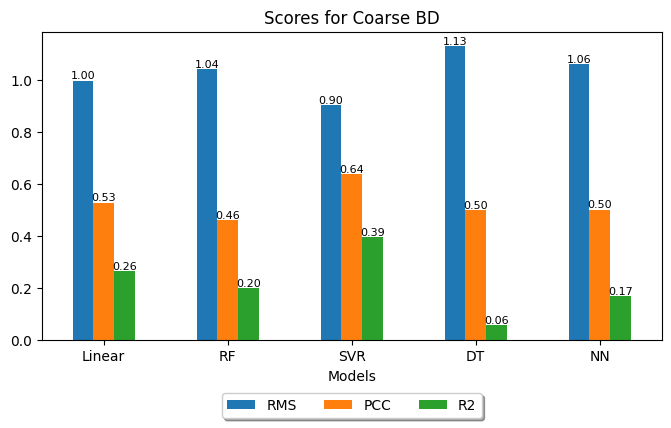

In [17]:

del EHMs_bd_coarse["Gaussian Process"]
ehm_utils.scores_graph(EHMs_bd_coarse, plot_title = 'Scores for Coarse BD')


In [18]:
EHMs_bd_coarse.keys()

dict_keys(['Linear', 'RF', 'SVR', 'DT', 'NN'])

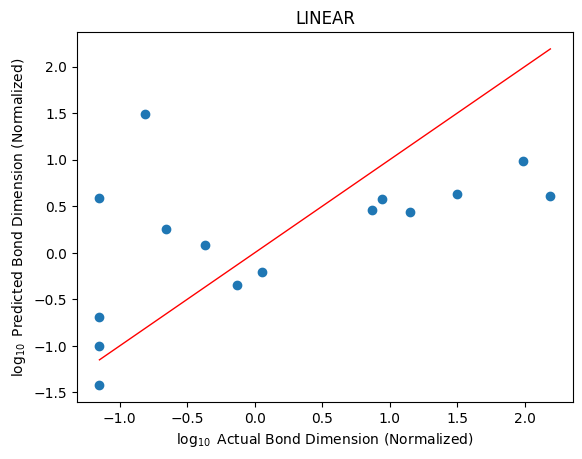

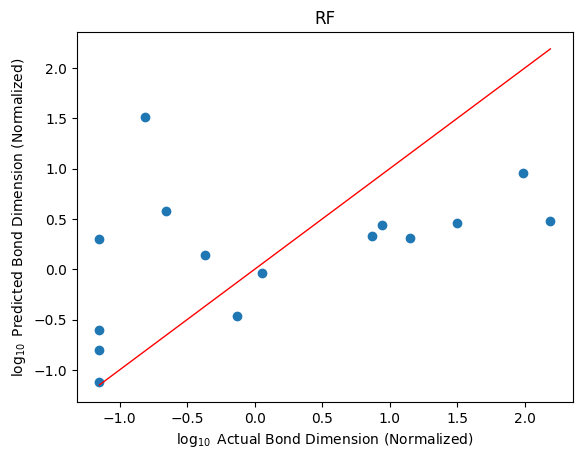

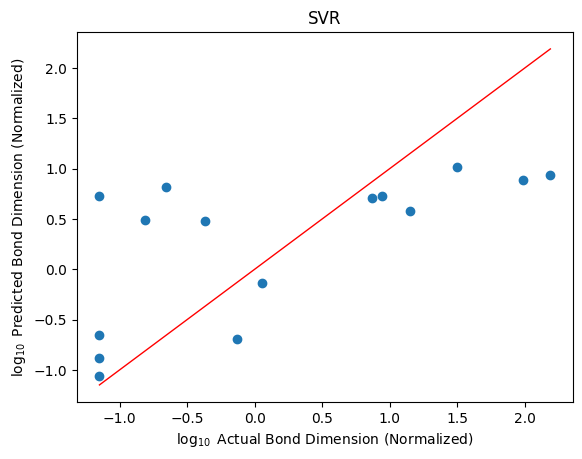

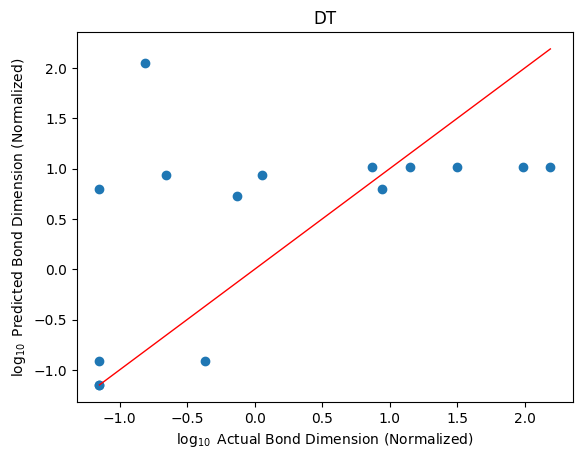

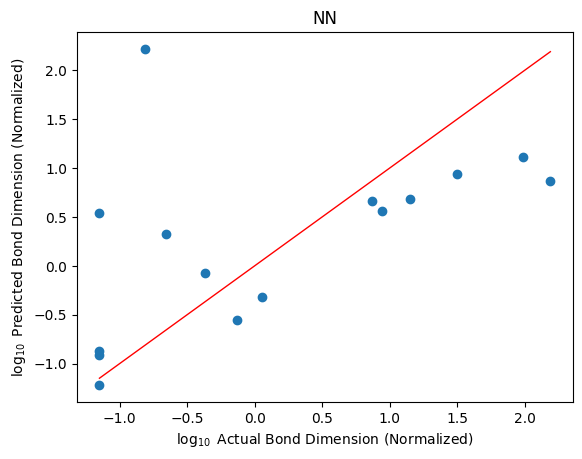

In [19]:
actual_axis_label = r'$\log_{10}$ Actual Bond Dimension (Normalized)'
predicted_axis_label = r'$\log_{10}$ Predicted Bond Dimension (Normalized)'


ehm_utils.plot_predicted_vs_actual(EHMs_bd_coarse, y_test, actual_axis_label, predicted_axis_label)

obt_diag_orig_l2_ratio        0.348109
log10_hilbert_space_size      0.343502
exchange_matrix_specL_mean    0.308389
dtype: float64


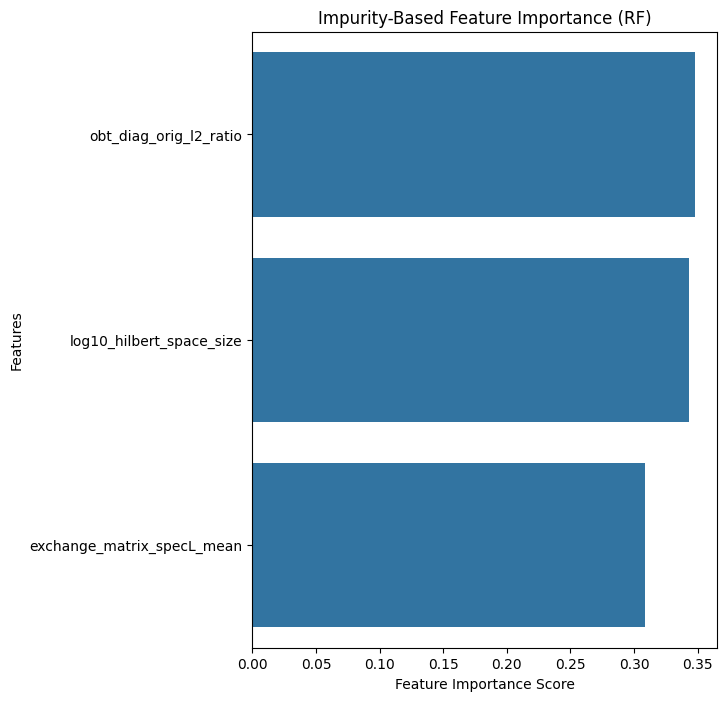

log10_hilbert_space_size      0.462290
obt_diag_orig_l2_ratio        0.459431
exchange_matrix_specL_mean    0.078279
dtype: float64


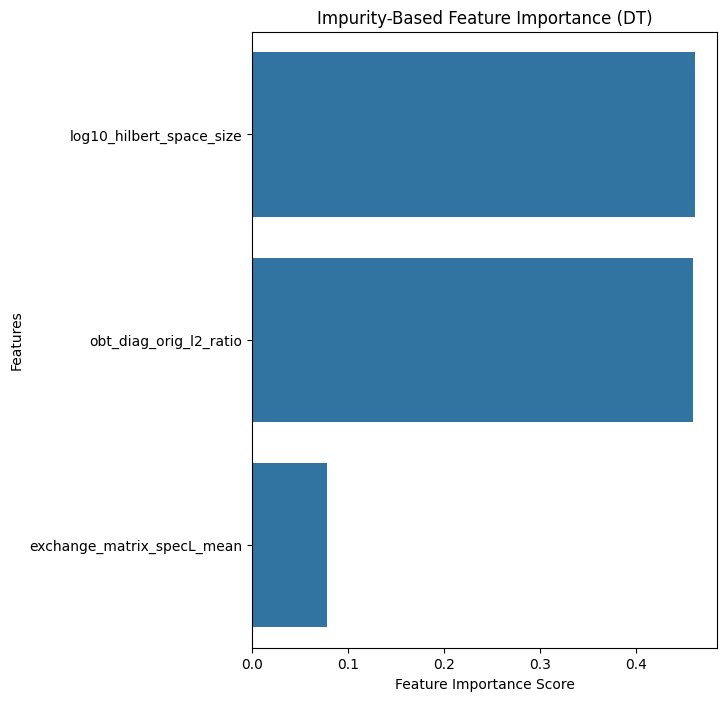

0.28224754333496094

In [20]:
start = time.time()
pd.set_option('display.max_rows', None)
ehm_utils.feature_importance_impurity(EHMs_bd_coarse,features)

feature_importance_impurity_Conc_time = time.time() - start
feature_importance_impurity_Conc_time

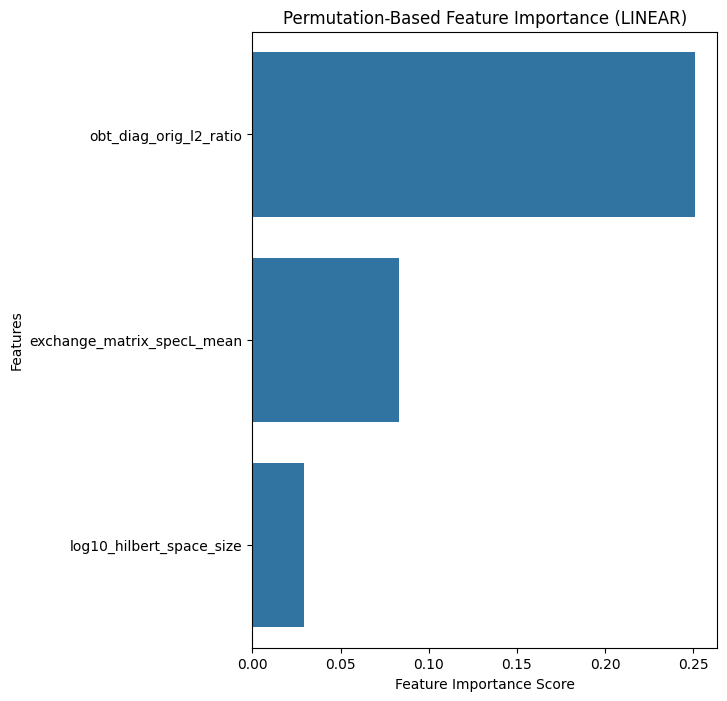

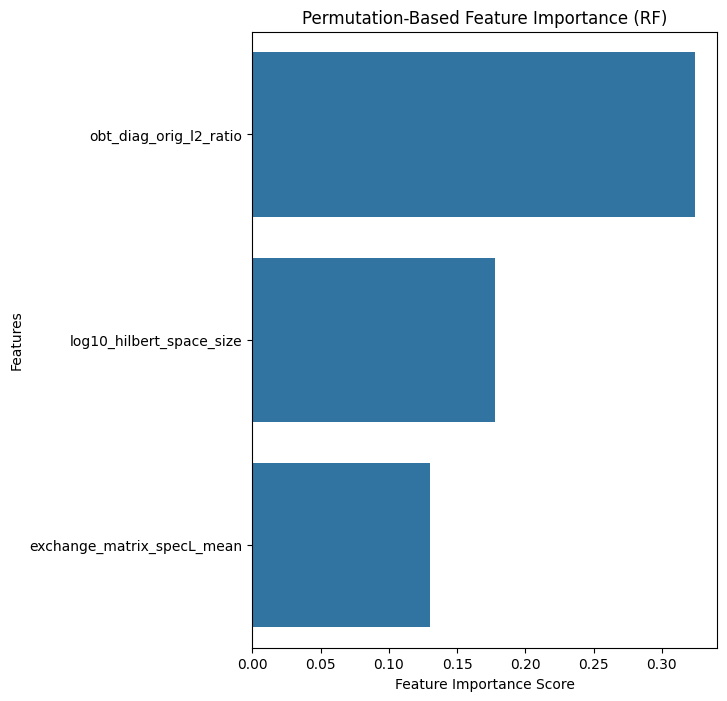

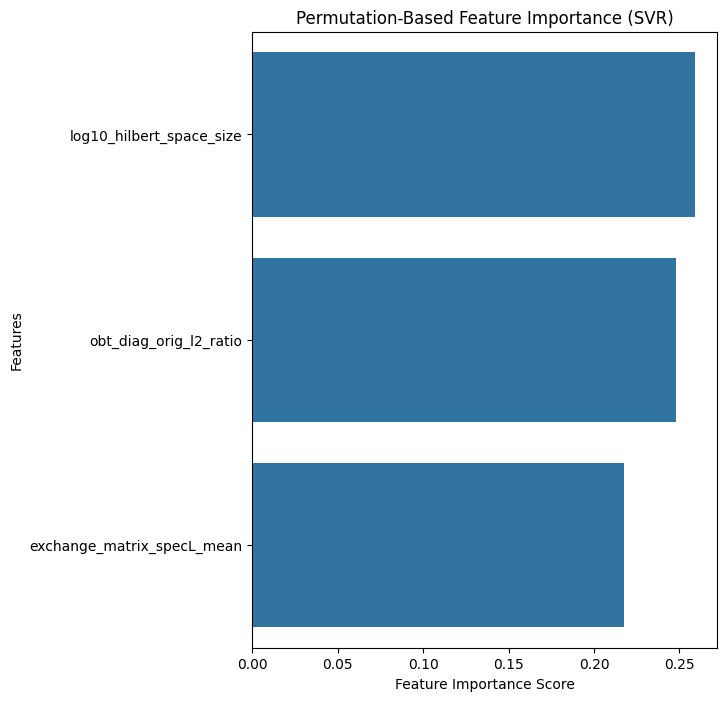

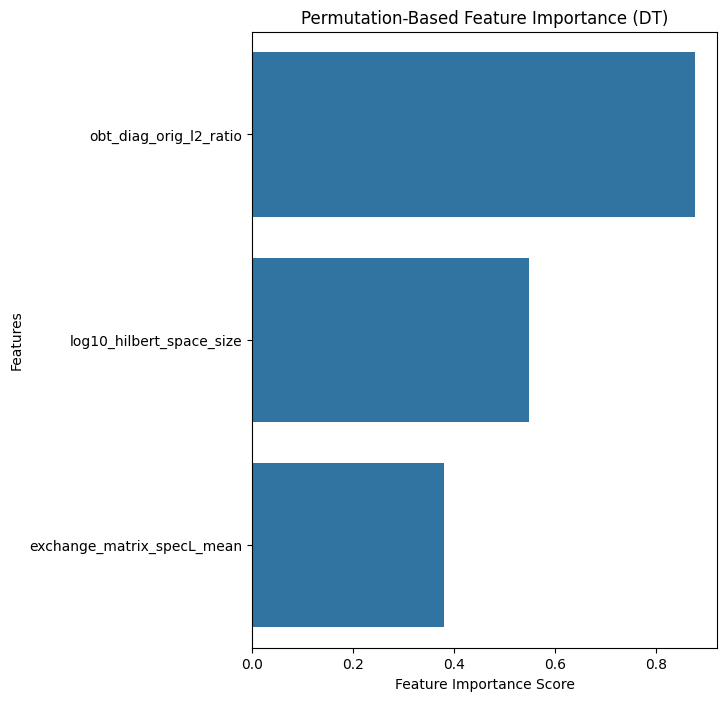

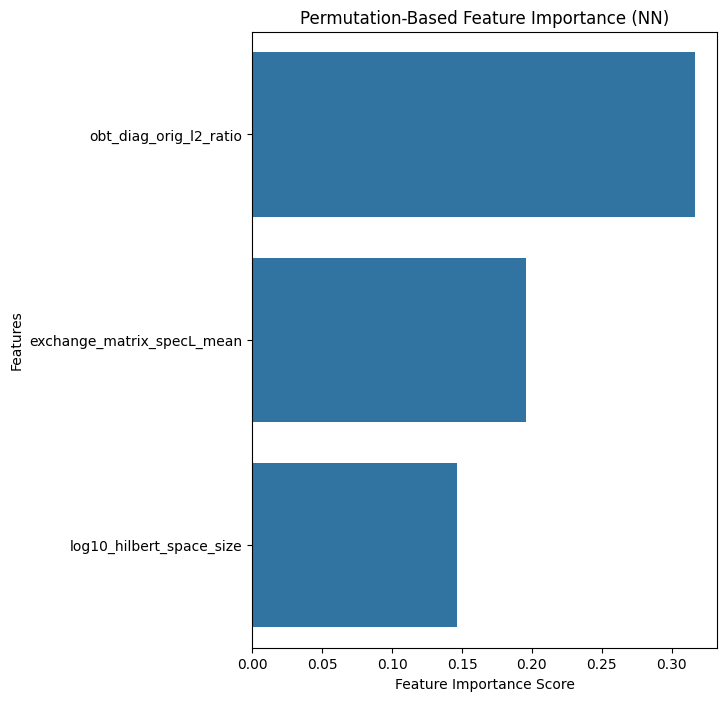

0.8992757797241211

In [21]:
start = time.time()

ehm_utils.feature_importance_permutation(EHMs_bd_coarse,features, X, y)

feature_importance_permutation_Conc_time = time.time() - start
feature_importance_permutation_Conc_time

In [22]:
# preproc_df_coarse_bd.plot(x='log10_hilbert_space_size', y='coarse_bond_dimension', kind='scatter')
# plt.xlabel('log10 Hilbert Space Size (Normalized)')
# plt.ylabel('Coarse Bond Dimension Estimate')
# preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_algebraic_connectivity', y='coarse_bond_dimension', kind='scatter')
# plt.xlabel('Algebraic Connectivity of Orbital Coupling Graph (Normalized)')
# plt.ylabel('Coarse Bond Dimension Estimate')
# preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_specA_mean', y='coarse_bond_dimension', kind='scatter')
# preproc_df_coarse_bd.plot(x='log10_hilbert_space_size', y='coulomb_matrix_algebraic_connectivity', kind='scatter')
# preproc_df_coarse_bd.plot(x='log10_hilbert_space_size', y='tbt_abs_graph_mapping_algebraic_connectivity', kind='scatter')

# # Pos
# # log10_hilbert_space_size
# # num_orbitals
# # coulomb_matrix_bandwidth_upper
# # coulomb_matrix_algebraic_connectivity
# # coulomb_matrix_edgeCount
# # coulomb_matrix_specA_max
# # coulomb_matrix_specA_power_spectral_entropy
# # coulomb_matrix_specR_power_spectral_entropy
# # exchange_matrix_specA_power_spectral_entropy
# # exchange_matrix_specR_min
# # exchange_matrix_specR_power_spectral_entropy
# # mean_field_calc_time_s
# # mean_field_matrix_algebraic_connectivity
# # mean_field_matrix_algebraic_connectivity_calc_time_s
# # mean_field_matrix_specA_max
# # mean_field_matrix_specA_power_spectral_entropy
# # mean_field_matrix_specL_std
# # mean_field_matrix_specR_power_spectral_entropy
# # tbt_graph_mapping_calc_time_s
# # tbt_abs_graph_mapping_calc_time_s
# # tbt_abs_graph_mapping_algebraic_connectivity ***
# # tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s
# # tbt_abs_graph_mapping_algebraic_connectivity_calc_time_s
# # tbt_abs_graph_mapping_specA_min
# # tbt_abs_graph_mapping_specA_Q2
# # tbt_abs_graph_mapping_specA_max
# # tbt_abs_graph_mapping_specA_mean **
# # tbt_abs_graph_mapping_specA_std
# # tbt_abs_graph_mapping_specA_coeff_variation
# # tbt_abs_graph_mapping_specA_power_spectral_entropy
# # tbt_abs_graph_mapping_specL_max
# # tbt_abs_graph_mapping_specL_std
# # tbt_abs_graph_mapping_specR_power_spectral_entropy
# # density_hopping_tensor_min
# # density_hopping_tensor_sum_abs

# #Neg
# # coulomb_matrix_specL_min
# # coulomb_matrix_specL_Q2
# # coulomb_matrix_specL_mean
# # coulomb_matrix_specR_min
# # exchange_matrix_specL_coeff_variation
# # exchange_matrix_specL_power_spectral_entropy
# # exchange_matrix_specR_max
# # exchange_matrix_specR_std
# # mean_field_matrix_specA_min
# # mean_field_matrix_specL_min
# # mean_field_matrix_specL_Q2
# # mean_field_matrix_specL_mean
# # mean_field_matrix_specR_min
# # tbt_abs_graph_mapping_specL_coeff_variation
# # tbt_abs_graph_mapping_specL_power_spectral_entropy
# # tbt_abs_graph_mapping_specR_max
# # tbt_abs_graph_mapping_specR_coeff_variation
# # density_hopping_tensor_coeff_variation
# # tbt_coeff_variation




In [23]:
# preproc_df_coarse_bd.plot(x='log10_hilbert_space_size', y='coarse_bond_dimension', kind='scatter')
# preproc_df_coarse_bd.plot(x='two_S', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='exchange_matrix_specA_power_spectral_entropy', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_specA_std', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_specA_power_spectral_entropy', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_specL_std', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='density_hopping_tensor_min', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='exchange_matrix_specL_coeff_variation', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='exchange_matrix_specL_power_spectral_entropy', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_specR_max', y='coarse_bond_dimension', kind='scatter')
# # preproc_df_coarse_bd.plot(x='tbt_abs_graph_mapping_specR_coeff_variation', y='coarse_bond_dimension', kind='scatter')


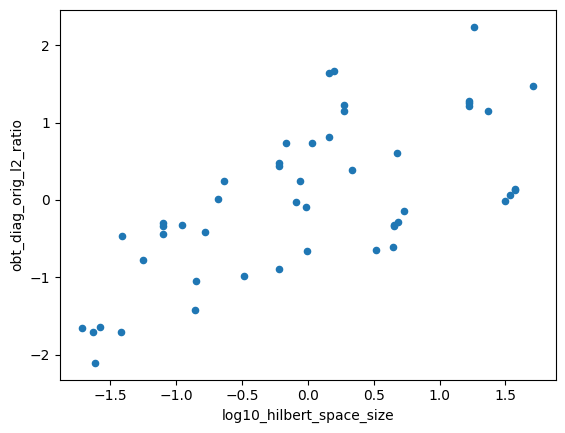

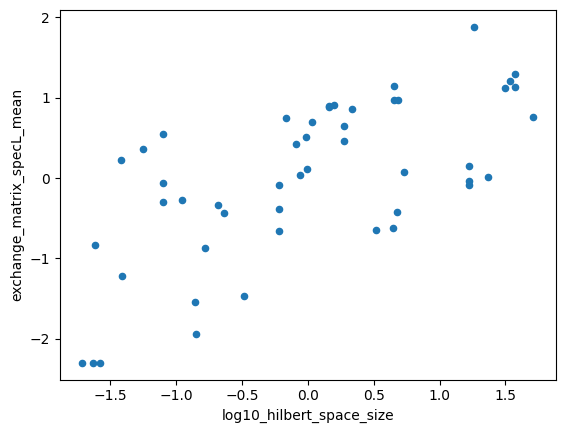

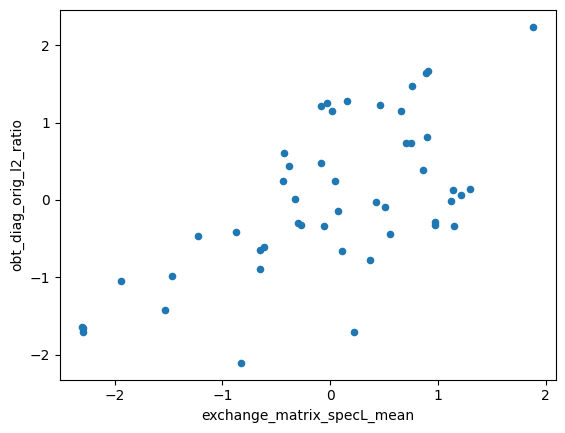

In [24]:
# Plot Hilbert Space Size vs obt_diag_orig_l2_ratio
ax_size_diag_dom = preproc_df_coarse_bd.plot(x='log10_hilbert_space_size', y='obt_diag_orig_l2_ratio', kind='scatter')

ax_size_diag_dom_y_lims = ax_size_diag_dom.get_ylim()
ax_size_diag_dom_x_lims = ax_size_diag_dom.get_xlim()

# Plot Hilbert Space Size vs exchange_matrix_specL_mean
ax_size_exch_mat =  preproc_df_coarse_bd.plot(x='log10_hilbert_space_size', y='exchange_matrix_specL_mean', kind='scatter')
ax_size_exch_mat_y_lims = ax_size_exch_mat.get_ylim()
ax_size_exch_mat_x_lims = ax_size_exch_mat.get_xlim()

# Plot exchange_matrix_specL_mean vs obt_diag_orig_l2_ratio
ax_exch_mat_diag_dom = preproc_df_coarse_bd.plot(x='exchange_matrix_specL_mean', y='obt_diag_orig_l2_ratio', kind='scatter')
ax_exch_mat_diag_dom_y_lims = ax_exch_mat_diag_dom.get_ylim()
ax_exch_mat_diag_dom_x_lims = ax_exch_mat_diag_dom.get_xlim()

In [25]:
def point_in_hull(point, hull, tolerance=1e-12):
    # From: https://stackoverflow.com/a/42165596/10548384
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

Text(0.5, 0.4, 'Num test points: 15')

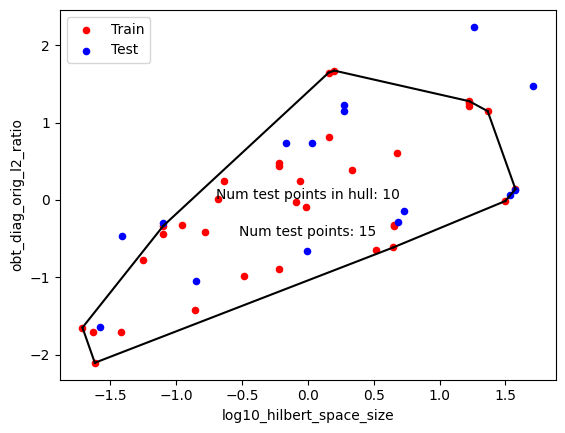

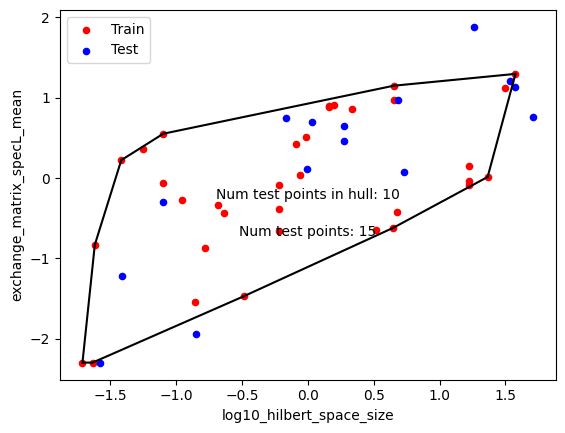

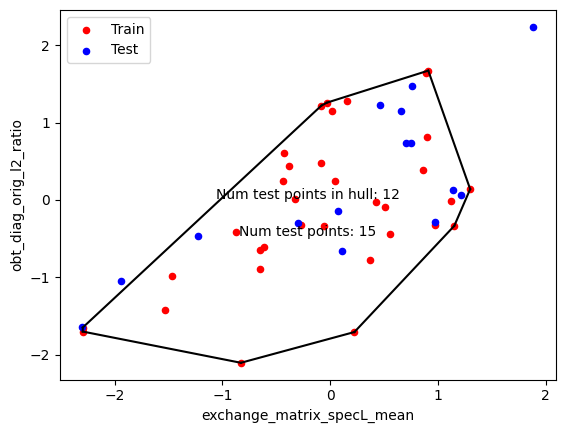

In [26]:
# Plot Hilbert Space Size vs obt_diag_orig_l2_ratio for test and train sets on same plot
ax_size_diag_dom_train = X_train.plot(x='log10_hilbert_space_size', y='obt_diag_orig_l2_ratio', kind='scatter', color='red')
X_test.plot(x='log10_hilbert_space_size', y='obt_diag_orig_l2_ratio', kind='scatter', color='blue',ax=ax_size_diag_dom_train)
ax_size_diag_dom_train.legend(['Train', 'Test'])
ax_size_diag_dom_train.set_ylim(ax_size_diag_dom_y_lims)
ax_size_diag_dom_train.set_xlim(ax_size_diag_dom_x_lims)

# Calculate and plot convex hull
hull = scipy.spatial.ConvexHull(X_train[['log10_hilbert_space_size', 'obt_diag_orig_l2_ratio']])
for simplex in hull.simplices:
    plt.plot(X_train['log10_hilbert_space_size'].iloc[simplex], X_train['obt_diag_orig_l2_ratio'].iloc[simplex], 'k-')
# plt.show()
#Calculate num test points in hull and put on plot
num_test_points_in_hull = 0
for i in range(len(X_test)):
    if point_in_hull(X_test[['log10_hilbert_space_size', 'obt_diag_orig_l2_ratio']].iloc[i], hull):
        num_test_points_in_hull += 1

plt.text(0.5, 0.5, f'Num test points in hull: {num_test_points_in_hull}', horizontalalignment='center', verticalalignment='center', transform=ax_size_diag_dom_train.transAxes)
plt.text(0.5, 0.4, f'Num test points: {len(X_test)}', horizontalalignment='center', verticalalignment='center', transform=ax_size_diag_dom_train.transAxes)


# Plot Hilbert Space Size vs exchange_matrix_specL_mean for test and train sets on same plot
ax_size_exch_mat_train = X_train.plot(x='log10_hilbert_space_size', y='exchange_matrix_specL_mean', kind='scatter', color='red')
X_test.plot(x='log10_hilbert_space_size', y='exchange_matrix_specL_mean', kind='scatter', color='blue',ax=ax_size_exch_mat_train)
ax_size_exch_mat_train.legend(['Train', 'Test'])
ax_size_exch_mat_train.set_ylim(ax_size_exch_mat_y_lims)
ax_size_exch_mat_train.set_xlim(ax_size_exch_mat_x_lims)

# Calculate and plot convex hull
hull = scipy.spatial.ConvexHull(X_train[['log10_hilbert_space_size', 'exchange_matrix_specL_mean']])
for simplex in hull.simplices:
    plt.plot(X_train['log10_hilbert_space_size'].iloc[simplex], X_train['exchange_matrix_specL_mean'].iloc[simplex], 'k-')
# plt.show()

#Calculate num test points in hull and put on plot
num_test_points_in_hull = 0
for i in range(len(X_test)):
    if point_in_hull(X_test[['log10_hilbert_space_size', 'exchange_matrix_specL_mean']].iloc[i], hull):
        num_test_points_in_hull += 1

plt.text(0.5, 0.5, f'Num test points in hull: {num_test_points_in_hull}', horizontalalignment='center', verticalalignment='center', transform=ax_size_exch_mat_train.transAxes)
plt.text(0.5, 0.4, f'Num test points: {len(X_test)}', horizontalalignment='center', verticalalignment='center', transform=ax_size_exch_mat_train.transAxes)

# Plot exchange_matrix_specL_mean vs obt_diag_orig_l2_ratio for test and train sets on same plot
ax_exch_mat_diag_dom_train = X_train.plot(x='exchange_matrix_specL_mean', y='obt_diag_orig_l2_ratio', kind='scatter', color='red')
X_test.plot(x='exchange_matrix_specL_mean', y='obt_diag_orig_l2_ratio', kind='scatter', color='blue',ax=ax_exch_mat_diag_dom_train)
ax_exch_mat_diag_dom_train.legend(['Train', 'Test'])
ax_exch_mat_diag_dom_train.set_ylim(ax_exch_mat_diag_dom_y_lims)
ax_exch_mat_diag_dom_train.set_xlim(ax_exch_mat_diag_dom_x_lims)

# Calculate and plot convex hull
hull = scipy.spatial.ConvexHull(X_train[['exchange_matrix_specL_mean', 'obt_diag_orig_l2_ratio']])
for simplex in hull.simplices:
    plt.plot(X_train['exchange_matrix_specL_mean'].iloc[simplex], X_train['obt_diag_orig_l2_ratio'].iloc[simplex], 'k-')

#Calculate num test points in hull and put on plot
num_test_points_in_hull = 0
for i in range(len(X_test)):
    if point_in_hull(X_test[['exchange_matrix_specL_mean', 'obt_diag_orig_l2_ratio']].iloc[i], hull):
        num_test_points_in_hull += 1

plt.text(0.5, 0.5, f'Num test points in hull: {num_test_points_in_hull}', horizontalalignment='center', verticalalignment='center', transform=ax_exch_mat_diag_dom_train.transAxes)
plt.text(0.5, 0.4, f'Num test points: {len(X_test)}', horizontalalignment='center', verticalalignment='center', transform=ax_exch_mat_diag_dom_train.transAxes)


In [27]:
# from pygel3d import hmesh

In [28]:





# def conv_hull_dist(hull, points):
#     # Construct PyGEL Manifold from the convex hull
#     m = hmesh.Manifold()
#     for s in hull.simplices:
#         m.add_face(hull.points[s])

#     dist = hmesh.MeshDistance(m)
#     res = []
#     for p in points:
#         # Get the distance to the point
#         # But don't trust its sign, because of possible
#         # wrong orientation of mesh face
#         d = dist.signed_distance(p)

#         # Correct the sign with ray inside test
#         if dist.ray_inside_test(p):
#             if d > 0:
#                 d *= -1
#         else:
#             if d < 0:
#                 d *= -1
#         res.append(d)
#     return np.array(res)

In [29]:
X_test

,log10_hilbert_space_size,exchange_matrix_specL_mean,obt_diag_orig_l2_ratio
23,-1.579958,-2.298642,-1.643882
27,-0.847489,-1.945045,-1.052762
12,1.712045,0.755896,1.474084
33,-1.412651,-1.223822,-0.462971
45,0.270006,0.463615,1.222062
1,0.728556,0.073544,-0.138686
44,-1.099152,-0.302272,-0.293633
8,1.260378,1.884223,2.239394
35,-0.164410,0.745457,0.740872
43,1.576067,1.140155,0.128769


In [30]:
X_test.to_numpy().shape

(15, 3)

In [31]:
#Calculate 3D convex hull
threeD_hull = scipy.spatial.ConvexHull(X_train[['log10_hilbert_space_size', 'exchange_matrix_specL_mean', 'obt_diag_orig_l2_ratio']])
num_test_points = X_test.shape[0]
num_test_points_in_hull = 0

sum_min_dist_to_hull = 0
for i in range(num_test_points):
    point = X_test.iloc[i]
    if point_in_hull(point, threeD_hull):
        num_test_points_in_hull += 1
    else:
        # Calculate distance to hull
        min_dist_to_hull = np.inf
        for equation in threeD_hull.equations:
            dist_denominator = np.sqrt(equation[0]**2 + equation[1]**2 + equation[2]**2)
            dist_numerator = equation[0]*point['log10_hilbert_space_size'] + equation[1]*point['exchange_matrix_specL_mean'] + equation[2]*point['obt_diag_orig_l2_ratio'] + equation[3]
            dist = np.abs(dist_numerator/dist_denominator)
            # print(f"Distance to hull: {dist}")
            min_dist_to_hull = min(min_dist_to_hull, dist)
        print(f"Min distance to hull: {min_dist_to_hull}")
        sum_min_dist_to_hull += min_dist_to_hull

# print(conv_hull_dist(hull, X_test.to_numpy()))

print(num_test_points_in_hull)
print(num_test_points)
print(sum_min_dist_to_hull)

Min distance to hull: 0.007287802753569107
Min distance to hull: 0.001210209030432452
Min distance to hull: 0.030528530968927714
Min distance to hull: 0.0026010268567255856
Min distance to hull: 0.0008435472043883951
Min distance to hull: 0.07542593270348152
Min distance to hull: 0.028364468934863774
Min distance to hull: 7.946179178874857e-05
7
15
0.1463409802441773


Kulback-Leibler Divergence: 1.8501845188084007


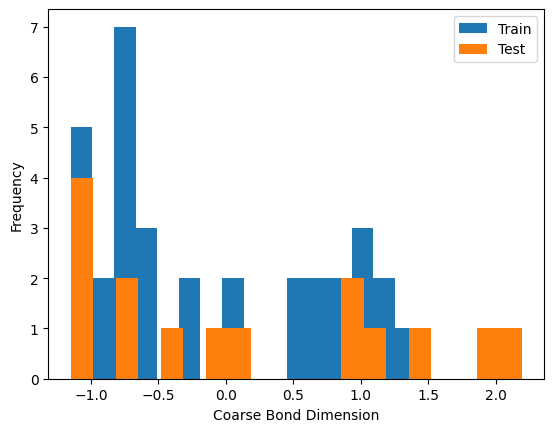

In [32]:
# Plot y_test and y_train to see coverage
y_train.plot(kind='hist',bins=20)
y_test.plot(kind='hist',bins=20)
plt.xlabel('Coarse Bond Dimension')
plt.ylabel('Frequency')
plt.legend(['Train', 'Test'])

# Calculate kulback-leibler divergence
y_test_bin_counts, _ = np.histogram(y_test, bins=20)
y_train_bin_counts, _ = np.histogram(y_train, bins=20)
# kl_divergence = scipy.stats.entropy(y_test_bin_counts+1, y_train_bin_counts+1)
kl_divergence = scipy.stats.entropy(y_test_bin_counts+0.001, y_train_bin_counts+0.001)
print(f"Kulback-Leibler Divergence: {kl_divergence}")

In [33]:
y_test.to_numpy().shape
y_train.to_numpy().shape

(34,)

In [34]:
# Get convex hull for  four d space including coarse bond dimension
combinded_train = X_train.copy()
combinded_train['coarse_bond_dimension'] = y_train
fourD_hull = scipy.spatial.ConvexHull(combinded_train[['log10_hilbert_space_size', 'exchange_matrix_specL_mean', 'obt_diag_orig_l2_ratio', 'coarse_bond_dimension']])
combined_test = X_test.copy()
combined_test['coarse_bond_dimension'] = y_test
num_test_points = combined_test.shape[0]
num_test_points_in_hull = 0

sum_min_dist_to_hull = 0
for i in range(num_test_points):
    point = combined_test.iloc[i]
    if point_in_hull(point, fourD_hull):
        num_test_points_in_hull += 1
    else:
        # Calculate distance to hull
        min_dist_to_hull = np.inf
        for equation in fourD_hull.equations:
            dist_denominator = np.sqrt(equation[0]**2 + equation[1]**2 + equation[2]**2 + equation[3]**2)
            dist_numerator = equation[0]*point['log10_hilbert_space_size'] + equation[1]*point['exchange_matrix_specL_mean'] + equation[2]*point['obt_diag_orig_l2_ratio'] + equation[3]*point['coarse_bond_dimension'] + equation[4]
            dist = np.abs(dist_numerator/dist_denominator)
            # print(f"Distance to hull: {dist}")
            min_dist_to_hull = min(min_dist_to_hull, dist)
        print(f"Min distance to hull: {min_dist_to_hull}")
        sum_min_dist_to_hull += min_dist_to_hull

print(num_test_points_in_hull)
print(num_test_points)
print(sum_min_dist_to_hull)

Min distance to hull: 0.0
Min distance to hull: 0.0
Min distance to hull: 0.003488293579404167
Min distance to hull: 0.0
Min distance to hull: 0.060340191652505704
Min distance to hull: 0.022940014394198575
Min distance to hull: 0.024138478548258457
Min distance to hull: 0.0
Min distance to hull: 0.018020241625949174
Min distance to hull: 0.002266963112594334
5
15
0.1311941829129104


In [35]:
y_test

23   -1.150156
27   -1.150156
12    1.985459
33   -1.150156
45    2.190388
1    -0.367566
44   -0.127882
8    -0.815352
35    1.154097
43   -1.150156
42    0.939759
3     0.051140
32    0.868066
47    1.502100
37   -0.656397
Name: coarse_bond_dimension, dtype: float64

In [36]:
y_train

46   -0.815352
38   -0.588503
39    1.154097
2    -1.150156
9     2.053670
26    0.126193
14    1.272666
4    -0.815352
13   -0.731450
30    0.504182
28   -0.731450
48    0.729760
21   -1.150156
18    1.154097
11    0.797654
29    0.051140
6    -0.910472
34   -0.656397
25   -1.150156
7     1.011774
24   -0.199176
19   -0.199176
5    -0.731450
17    0.729760
40    0.797654
20   -1.020280
15    0.504182
10   -0.731450
0    -1.150156
31   -0.731450
41    0.939759
22   -0.910472
16   -0.588503
36    1.011774
Name: coarse_bond_dimension, dtype: float64

In [37]:
# Calc the pearson correlation coefficient between pairs of features

corr_mat_df = mlData.corr()
corr_mat_df

,log10_hilbert_space_size,exchange_matrix_specL_mean,obt_diag_orig_l2_ratio,coarse_bond_dimension
log10_hilbert_space_size,1.000000,0.664299,0.671542,0.487957
exchange_matrix_specL_mean,0.664299,1.000000,0.646658,0.514538
obt_diag_orig_l2_ratio,0.671542,0.646658,1.000000,0.625534
coarse_bond_dimension,0.487957,0.514538,0.625534,1.000000


In [38]:
np.abs(corr_mat_df["coarse_bond_dimension"]).sort_values(ascending=False)

coarse_bond_dimension         1.000000
obt_diag_orig_l2_ratio        0.625534
exchange_matrix_specL_mean    0.514538
log10_hilbert_space_size      0.487957
Name: coarse_bond_dimension, dtype: float64

In [39]:
corr_mat_df["coarse_bond_dimension"]

log10_hilbert_space_size      0.487957
exchange_matrix_specL_mean    0.514538
obt_diag_orig_l2_ratio        0.625534
coarse_bond_dimension         1.000000
Name: coarse_bond_dimension, dtype: float64

In [40]:

np.abs(corr_mat_df["exchange_matrix_specL_mean"]).sort_values(ascending=False)

exchange_matrix_specL_mean    1.000000
log10_hilbert_space_size      0.664299
obt_diag_orig_l2_ratio        0.646658
coarse_bond_dimension         0.514538
Name: exchange_matrix_specL_mean, dtype: float64

In [41]:
pca_df = mlData.drop(target_perf_metric, axis = 1, inplace = False)
pca = PCA(n_components=pca_df.shape[1])
pca.fit(pca_df)

PCA(n_components=3)

                                 PC0       PC1       PC2
log10_hilbert_space_size   -0.581444 -0.114853  0.805439
exchange_matrix_specL_mean -0.574222  0.759259 -0.306261
obt_diag_orig_l2_ratio     -0.576361 -0.640574 -0.507417


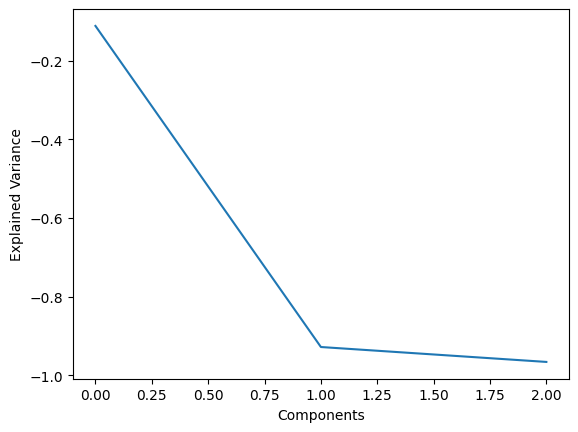

In [42]:
# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(pca_df.columns))],
index=pca_df.columns)
print(loadings)

plt.plot(np.log10(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [43]:

np.abs(corr_mat_df["coarse_bond_dimension"]).sort_values(ascending=False)

coarse_bond_dimension         1.000000
obt_diag_orig_l2_ratio        0.625534
exchange_matrix_specL_mean    0.514538
log10_hilbert_space_size      0.487957
Name: coarse_bond_dimension, dtype: float64

In [44]:
np.abs(corr_mat_df["hubbard_dist_tbt"]).sort_values(ascending=False)

KeyError: 'hubbard_dist_tbt'

In [ ]:
np.abs(corr_mat_df["density_hopping_tensor_coeff_variation"]).sort_values(ascending=False)

In [ ]:
corr_mat_df[np.abs(corr_mat_df)>0.8]["log10_hilbert_space_size"]

In [ ]:
# corr_mat_df["log10_hilbert_space_size"].loc[np.abs(corr_mat_df["log10_hilbert_space_size"]) > 0.8]

In [ ]:
# corr_mat_df["coulomb_matrix_algebraic_connectivity"].loc[np.abs(corr_mat_df["coulomb_matrix_algebraic_connectivity"]) > 0.8]

In [ ]:
# corr_mat_df["tbt_abs_graph_mapping_algebraic_connectivity"].loc[np.abs(corr_mat_df["tbt_abs_graph_mapping_algebraic_connectivity"]) > 0.8]

In [ ]:

np.abs(corr_mat_df["coulomb_matrix_specR_min"]).sort_values(ascending=False)

In [ ]:

np.abs(corr_mat_df["coarse_bond_dimension"]).sort_values(ascending=False)
# np.abs(corr_mat_df["coarse_bond_dimension"].loc[np.abs(corr_mat_df["coarse_bond_dimension"]) > 0.3]).sort_values(ascending=False)

In [ ]:
# Calc the pearson correlation coefficient between pairs of features
corr_mat_df_scc = mlData.corr(method='spearman')
# corr_mat_df_scc
np.abs(corr_mat_df_scc["coarse_bond_dimension"]).sort_values(ascending=False)

In [ ]:
np.abs(corr_mat_df_scc["coarse_bond_dimension"])

In [ ]:
prod_df= np.abs(corr_mat_df["coarse_bond_dimension"])/np.abs(corr_mat_df)
prod_df/=np.max(prod_df)
prod_df=np.log10(prod_df)
prod_df[(prod_df)>-2].count()
# prod_df[np.logical_and((prod_df)>0.3,(prod_df)<0.4)].count()

In [48]:
# import networkx as nx

# adj_mat = np.array([[5, 1, 1, 0], [1, 65100, 1, 0], [1, 1, 0, 1], [0, 0, 1, 0]])
# G = nx.from_numpy_array(adj_mat)
# print(nx.adjacency_matrix(G).toarray())
# print(nx.laplacian_matrix(G).toarray())

[[    5     1     1     0]
 [    1 65100     1     0]
 [    1     1     0     1]
 [    0     0     1     0]]
[[ 2 -1 -1  0]
 [-1  2 -1  0]
 [-1 -1  3 -1]
 [ 0  0 -1  1]]
